## Projet 5 : Segmentez des clients d'un site e-commerce

## Contexte

Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.

Première urgence : l'implémentation de requêtes SQL urgentes.

Deuxième urgence :  fournir aux équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

## Librairies utilisées avec le langage Python:

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sqlite3
# from IPython.display import Image
# from sklearn.preprocessing import LabelEncoder # sklearn preprocessing for dealing with categorical variables
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import train_test_split
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
 # Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def show_miss_val(data):
    variables = []
    miss_val = []

    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean()) #Calcul du pourcentage de valeurs manquantes

    # Création d'un dataframe avec le résultat
    output = pd.DataFrame({
        'variable': variables,
        'miss_val': miss_val
    })
    # Affichage d'un message récapitulant le nombre de variables et le nombre d'entre elles qui a des valeurs manquantes
    print ("Notre dataframe a " + str(data.shape[1]) + " variables.\n Il y a " + str(output[output['miss_val']!=0].shape[0]) +" variables contenant des valeurs manquantes.")

    # Retourne les colonnes qui ont des valeurs manquantes avec le pourcentage de valeurs manquantes de chacune d'entre elles
    return output[output['miss_val']!=0].sort_values('miss_val')

In [3]:
def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    '''Take a Pandas dataframe `input_df` and upload it to `table_name` SQLITE table
    Args:
        input_df (pd.DataFrame): Dataframe containing data to upload to SQLITE
        table_name (str): Name of the SQLITE table to upload to
        db_name (str, optional): Name of the SQLITE Database in which the table is created.
                                 Defaults to 'default.db'.
    '''

    # Step 1: Setup local logging
    import logging
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s: %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')

    # Step 2: Find columns in the dataframe
    cols = input_df.columns
    cols_string = ','.join(cols)
    val_wildcard_string = ','.join(['?'] * len(cols))

    # Step 3: Connect to a DB file if it exists, else crete a new file
    con = sqlite3.connect(db_name)
    cur = con.cursor()
    logging.info(f'SQL DB {db_name} created')

    # Step 4: Create Table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    cur.execute(sql_string)
    logging.info(f'SQL Table {table_name} created with {len(cols)} columns')

    # Step 5: Upload the dataframe
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""
    cur.executemany(sql_string, rows_to_upload)
    logging.info(f'{len(rows_to_upload)} rows uploaded to {table_name}')

    # Step 6: Commit the changes and close the connection
    con.commit()
    con.close()

In [4]:
def sql_query_to_pd(sql_query_string: str, db_name: str ='default.db') -> pd.DataFrame:
    '''Execute an SQL query and return the results as a pandas dataframe
    Args:
        sql_query_string (str): SQL query string to execute
        db_name (str, optional): Name of the SQLITE Database to execute the query in.
                                 Defaults to 'default.db'.
    Returns:
        pd.DataFrame: Results of the SQL query in a pandas dataframe
    '''
    # Step 1: Connect to the SQL DB
    con = sqlite3.connect(db_name)

    # Step 2: Execute the SQL query
    cursor = con.execute(sql_query_string)

    # Step 3: Fetch the data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # Step 4: Close the connection
    con.close()

    # Step 5: Return as a dataframe
    return pd.DataFrame(result_data, columns=cols)

## Clustering RFM :


Pour effectuer le clustering selon les variables RFM (standard du ciblage marketing), nous agrègerons les données par client et non pas par commande dans un premier temps, puis nous créerons ces variables RFM (Récence, Fréquence, Montant) par client.

In [5]:
# Chargement des données brutes du fichier CSV
data_fe = pd.read_csv('/tutorial-env/OCR/Projet5/data_fe.csv')
data_fe_client = pd.read_csv('/tutorial-env/OCR/Projet5/data_fe_client.csv')

In [7]:
pd_to_sqlDB(data_fe,
            table_name='data_fe_CL',
            db_name='/tutorial-env/OCR/Projet5/olist.db')

sql_query_string = """
WITH cte AS (
    SELECT MAX(order_purchase_date) AS date_max
    FROM data_fe_CL
)

SELECT customer_unique_id,COUNT(order_id) AS Frequence,julianday(date_max) - julianday(MAX(order_purchase_date)) AS recence,SUM(payment_total) AS montant
FROM data_fe_CL,cte
GROUP BY 1
ORDER BY 1
"""

df_temp=sql_query_to_pd(sql_query_string, db_name='/tutorial-env/OCR/Projet5/olist.db')

2024-10-01 11:30:13 INFO: SQL DB /tutorial-env/OCR/Projet5/olist.db created
2024-10-01 11:30:13 INFO: SQL Table data_fe_CL created with 18 columns
2024-10-01 11:30:14 INFO: 99441 rows uploaded to data_fe_CL


In [8]:
# Création du dataframe RFM :
data_rfm = pd.DataFrame(df_temp)

In [9]:
data_rfm.describe()

Frequence       recence       montant
count  96096.000000  96096.000000  96095.000000
mean       1.034809    288.108797    166.594226
std        0.214384    153.417869    231.428912
min        1.000000      0.000000      0.000000
25%        1.000000    164.000000     63.120000
50%        1.000000    269.000000    108.000000
75%        1.000000    397.000000    183.530000
max       17.000000    773.000000  13664.080000

In [10]:
data_rfm.to_csv('D:/tutorial-env/OCR/Projet5/data_rfm_client.csv', index=False)

### Analyse des variables :

Analysons maintenant les variables RFM :

In [11]:
def describe_data_quant(data, col):
    data_des = data.describe()
    df = pd.DataFrame({'Caractéristiques': data_des[col].index,
                           'Valeurs': data_des[col].values
                           })

    sns.set_style("whitegrid")
    ax = sns.boxplot(x=data[col])


    plt.figure(figsize=(9, 8))
    sns.distplot(data[col], color='blue', kde=True)
    plt.title(f'Distribution de {col}')
    plt.ylabel("Fréquence de la donnée")
    plt.grid()
    plt.show()

    return df.style.set_caption(f'Caractéristiques {col}')

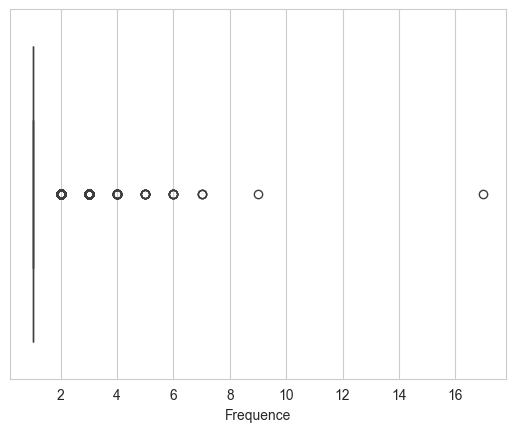

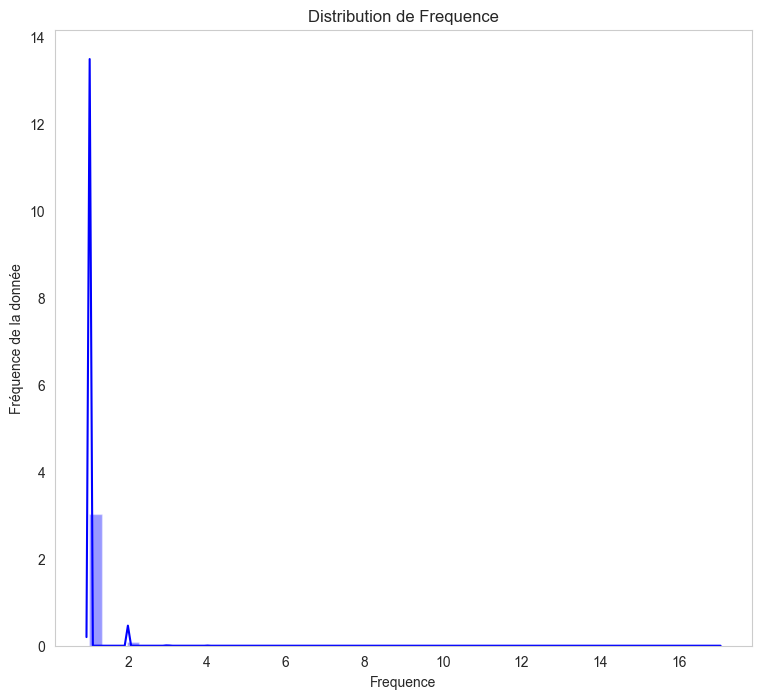

In [12]:
describe_data_quant(data_rfm, 'Frequence')

Quasiment la totalité des fréquences sont égales à 1 donc cette variable ne devrait pas aider pour le clustering.

Faisons une transformation racine carrée de cette variable :

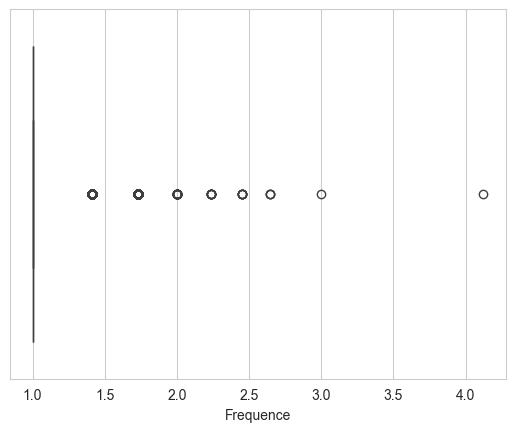

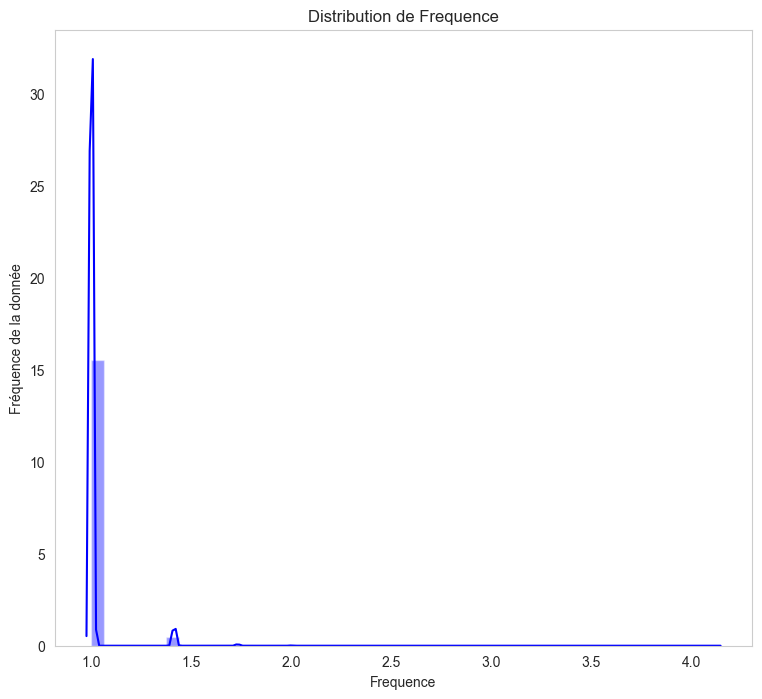

In [13]:
# Création d'un dataframe après transformation en racine carré
data_rfm_sqrt = pd.DataFrame()
data_rfm_sqrt['Frequence']= np.sqrt(data_rfm['Frequence'])

describe_data_quant(data_rfm_sqrt, 'Frequence')

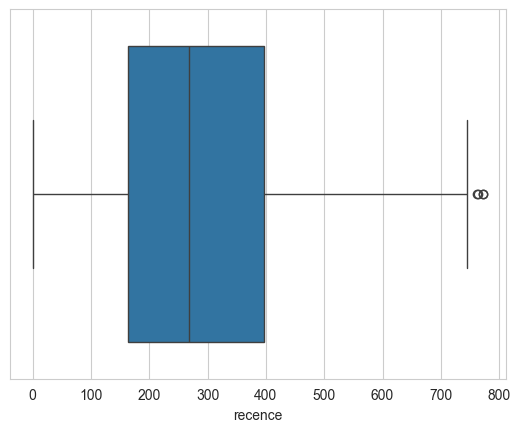

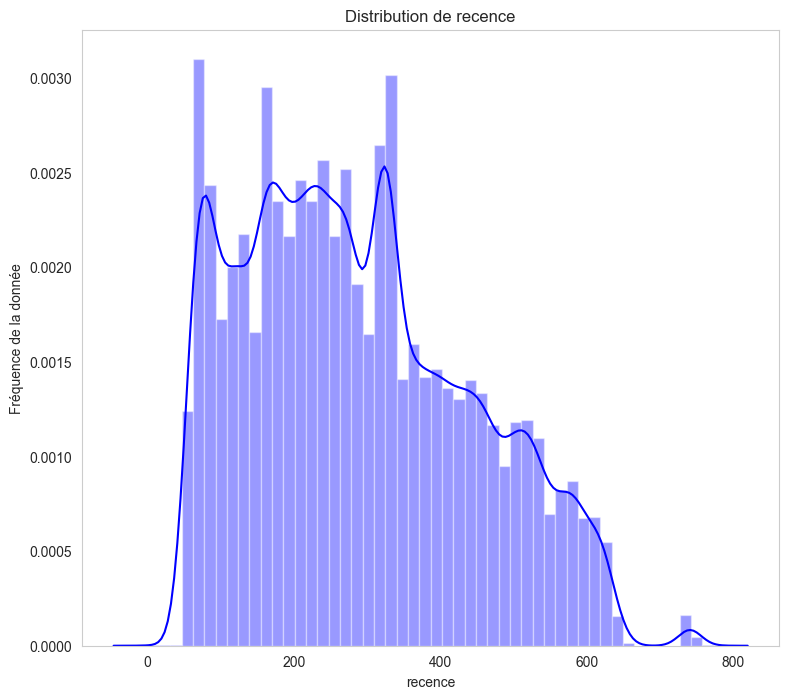

In [14]:
data_rfm_sqrt['recence']= data_rfm['recence']
describe_data_quant(data_rfm, 'recence')

La variable "recence" a plus de variance et pourra être potentiellement utile pour le clustering.

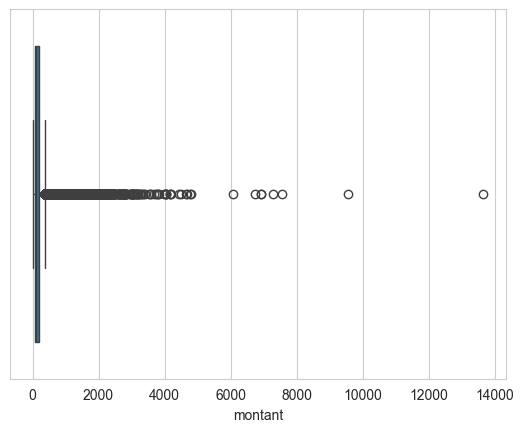

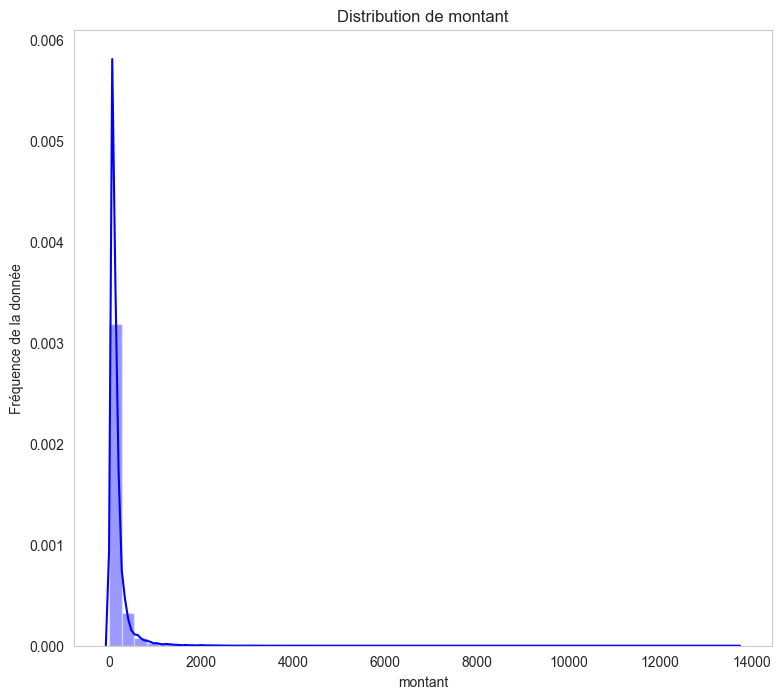

In [15]:
describe_data_quant(data_rfm, 'montant')

La variable "montant" a plus de variance et pourra être potentiellement utile pour le clustering.

Faisons une transformation racine carrée de cette variable :

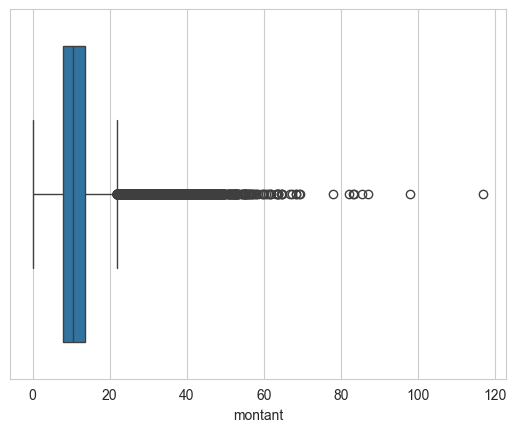

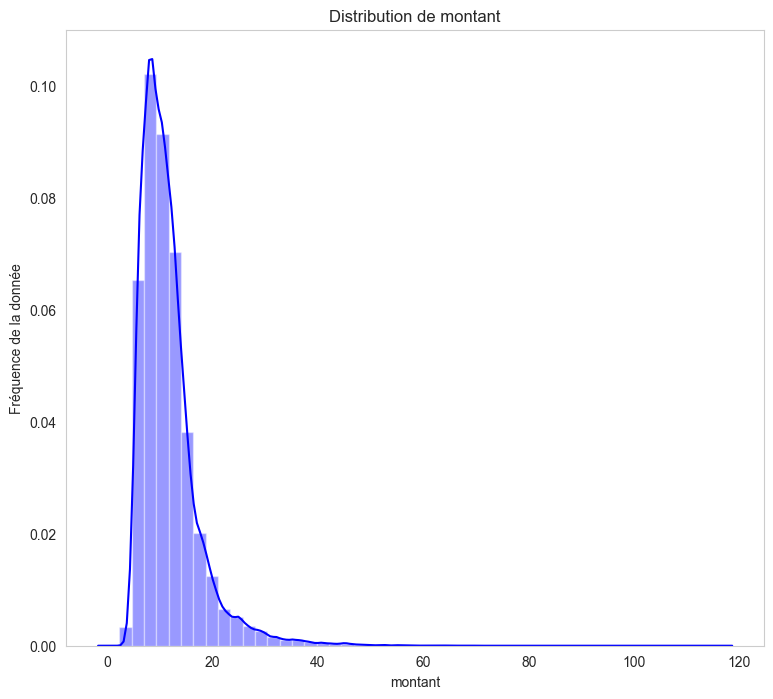

In [16]:
data_rfm_sqrt['montant']= np.sqrt(data_rfm['montant'])

describe_data_quant(data_rfm_sqrt, 'montant')

In [17]:
# Traitement des outliers par la méthode de la distance interquartile
q1_f=data_rfm["Frequence"].quantile(q=0.25)
q3_f=data_rfm["Frequence"].quantile(q=0.75)
q1_r=data_rfm["recence"].quantile(q=0.25)
q3_r=data_rfm["recence"].quantile(q=0.75)
q1_m=data_rfm["montant"].quantile(q=0.25)
q3_m=data_rfm["montant"].quantile(q=0.75)

IQR_f=q3_f-q1_f
IQR_r=q3_r-q1_r
IQR_m=q3_m-q1_m

borne_inf_f = q1_f-1.5*IQR_f
borne_sup_f = q3_f +1.5*IQR_f
borne_inf_r = q1_r-1.5*IQR_r
borne_sup_r = q3_r +1.5*IQR_r
borne_inf_m = q1_m-1.5*IQR_m
borne_sup_m = q3_m +1.5*IQR_m

# On crée une nouvelle colonne pour identifier les valeurs considérées comme atypique via la méthode de la distance interquartile
data_vat= data_rfm.loc[(data_rfm["Frequence"]>borne_sup_f)|(data_rfm["Frequence"]<borne_inf_f) ]
data_vat

#  Frquence >1 outliers car seulement 3% de la population (graphique camembert a faire), le dire mais ne pas enlever les outliers car sinon frequence inutile pour la segmentation

customer_unique_id  Frequence  recence  montant
33     00172711b30d52eea8b313a7f2cced02          2     65.0   244.14
106    004288347e5e88a27ded2bb23747066c          2    276.0   354.37
124    004b45ec5c64187465168251cd1c9c2f          2    144.0   147.72
144    0058f300f57d7b93c477a131a59b36c3          2    209.0   175.58
249    00a39521eb40f7012db50455bf083460          2    136.0   123.25
...                                 ...        ...      ...      ...
95784  ff36be26206fffe1eb37afd54c70e18b          3     55.0   278.28
95810  ff44401d0d8f5b9c54a47374eb48c1b8          2    516.0    68.00
95916  ff8892f7c26aa0446da53d01b18df463          2    325.0   330.14
95934  ff922bdd6bafcdf99cb90d7f39cea5b3          3    398.0   139.60
96050  ffe254cc039740e17dd15a5305035928          2    563.0    80.12

[2997 rows x 4 columns]

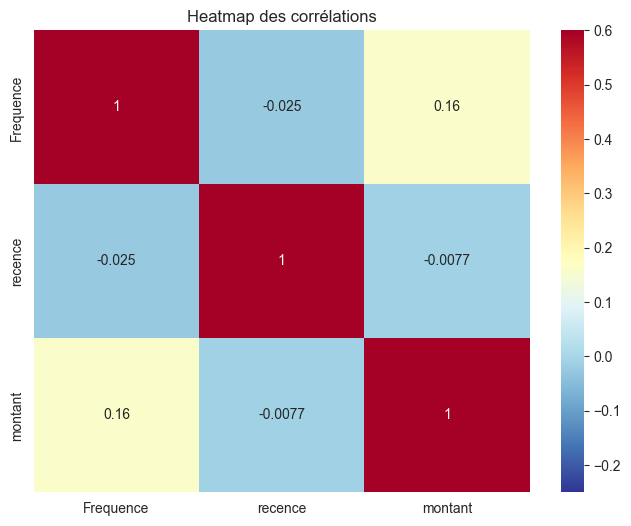

In [18]:
plt.figure(figsize = (8, 6))
data_corr = data_rfm_sqrt.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

Il n'y a pas de corrélations entre ces trois variables, ce qui est important pour le clustering.

In [19]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_rfm_vm=show_miss_val(data_rfm_sqrt)
data_rfm_vm.head(26)

Notre dataframe a 3 variables.
 Il y a 1 variables contenant des valeurs manquantes.


variable  miss_val
2  montant   0.00001

Il y a très peu de valeurs manquantes mais nous allons quand même imputer par la médiane pour que l'ensemble du jeu de données puisse être utilisé dans le clustering.

In [20]:
# Créer une instance de SimpleImputer
imputer = SimpleImputer(strategy='median')
# Remodeler la colonne en un tableau 2D
data_temp = data_rfm_sqrt['montant'].values.reshape(-1, 1)
data_rfm_sqrt['montant'] = imputer.fit_transform(data_temp)


In [21]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_rfm_vm=show_miss_val(data_rfm_sqrt)
data_rfm_vm.head(26)

Notre dataframe a 3 variables.
 Il y a 0 variables contenant des valeurs manquantes.


Empty DataFrame
Columns: [variable, miss_val]
Index: []

Nous avons imputé toutes les valeurs manquantes par la médiane, enlevons la
colonne avec les identifiants clients et normalisons maintenant notre dataframe :

In [22]:
# Créer une instance de Scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

# Normalisation des données
data_rfm_norm = pd.DataFrame(scaler.fit_transform(data_rfm_sqrt),columns=data_rfm_sqrt.columns)

data_rfm_norm.describe(include="all")

Frequence       recence       montant
count  96096.000000  96096.000000  96096.000000
mean       0.004479      0.372715      0.099257
std        0.026083      0.198471      0.048376
min        0.000000      0.000000      0.000000
25%        0.000000      0.212160      0.067966
50%        0.000000      0.347995      0.088904
75%        0.000000      0.513583      0.115895
max        1.000000      1.000000      1.000000

### KMeans avec 3 clusters :

Faisons maintenant le clustering avec l'algorithme du K-means car c'est le modèle non-supervisé le plus simple à utiliser, et le plus rapide à entraîner. Il est donc le modèle le plus adapté pour notre problématique. De plus, nous pouvons choisir explicitement le nombre de clusters.

Ce modèle n'est pas adapté aux clusters de topologie complexe.

In [23]:
kmeans = KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=300, random_state=42)

kmeans.fit(data_rfm_norm)

# Ajout des labels de cluster au dataframe
data_rfm_norm['cluster'] = kmeans.labels_

In [24]:
data_rfm_norm

Frequence   recence   montant  cluster
0            0.0  0.206986  0.101906        0
1            0.0  0.210867  0.044608        0
2            0.0  0.758085  0.079435        2
3            0.0  0.478655  0.056501        1
4            0.0  0.435964  0.120039        1
...          ...       ...       ...      ...
96091        0.0  0.641656  0.388977        2
96092        0.0  0.402329  0.078676        1
96093        0.0  0.798189  0.090721        2
96094        0.0  0.217335  0.098914        0
96095        0.0  0.689521  0.072368        2

[96096 rows x 4 columns]

In [25]:
# Ajout de la colonne "cluster" au jeu de données RFM :
data_rfm_cluster = data_rfm.merge(data_rfm_norm['cluster'],left_index=True, right_index=True, how='left')
data_rfm_cluster

customer_unique_id  Frequence  recence  montant  cluster
0      0000366f3b9a7992bf8c76cfdf3221e2          1    160.0   141.90        0
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1    163.0    27.19        0
2      0000f46a3911fa3c0805444483337064          1    586.0    86.22        2
3      0000f6ccb0745a6a4b88665a16c9f078          1    370.0    43.62        1
4      0004aac84e0df4da2b147fca70cf8255          1    337.0   196.89        1
...                                 ...        ...      ...      ...      ...
96091  fffcf5a5ff07b0908bd4e2dbc735a684          1    496.0  2067.42        2
96092  fffea47cd6d3cc0a88bd621562a9d061          1    311.0    84.58        1
96093  ffff371b4d645b6ecea244b27531430a          1    617.0   112.46        2
96094  ffff5962728ec6157033ef9805bacc48          1    168.0   133.69        0
96095  ffffd2657e2aad2907e67c3e9daecbeb          1    533.0    71.56        2

[96096 rows x 5 columns]

In [26]:
# Ajout de la colonne "cluster" au jeu de données issu du feature engineering et supression des variables doublons:
data_fe_cluster = data_fe_client.merge(data_rfm_cluster, on='customer_unique_id', how='left')
cols_to_drop = ["order_id", "payment_total"]
data_fe_cluster = data_fe_cluster.drop(cols_to_drop, axis=1)
data_fe_cluster

customer_unique_id  estimated_delivery_delay  \
0      0000366f3b9a7992bf8c76cfdf3221e2                      11.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                       8.0   
2      0000f46a3911fa3c0805444483337064                      28.0   
3      0000f6ccb0745a6a4b88665a16c9f078                      32.0   
4      0004aac84e0df4da2b147fca70cf8255                      21.0   
...                                 ...                       ...   
96091  fffcf5a5ff07b0908bd4e2dbc735a684                      55.0   
96092  fffea47cd6d3cc0a88bd621562a9d061                      33.0   
96093  ffff371b4d645b6ecea244b27531430a                      45.0   
96094  ffff5962728ec6157033ef9805bacc48                      26.0   
96095  ffffd2657e2aad2907e67c3e9daecbeb                      24.0   

       true_delivery_delay  late_delivery   price  freight_value  \
0                      6.0           -5.0  129.90          12.00   
1                      3.0           -5.0   18.90           8.29   
2                     26.0           -2.0   69.00          17.22   
3                     20.0          -12.0   25.99          17.63   
4                     13.0           -8.0  180.00          16.89   
...                    ...            ...     ...            ...   
96091                 28.0          -27.0  680.00         239.14   
96092                 30.0           -3.0   64.89          19.69   
96093                 15.0          -30.0   89.90          22.56   
96094                 12.0          -14.0  115.00          18.69   
96095                  8.0          -16.0   56.99          14.57   

       payment_payment_installments  review_score_moy  Frequence  recence  \
0                               8.0               5.0          1    160.0   
1                               1.0               4.0          1    163.0   
2                               8.0               3.0          1    586.0   
3                               4.0               4.0          1    370.0   
4                               6.0               5.0          1    337.0   
...                             ...               ...        ...      ...   
96091                          10.0               5.0          1    496.0   
96092                           1.0               4.0          1    311.0   
96093                           1.0               5.0          1    617.0   
96094                           5.0               5.0          1    168.0   
96095                           4.0               5.0          1    533.0   

       montant  cluster  
0       141.90        0  
1        27.19        0  
2        86.22        2  
3        43.62        1  
4       196.89        1  
...        ...      ...  
96091  2067.42        2  
96092    84.58        1  
96093   112.46        2  
96094   133.69        0  
96095    71.56        2  

[96096 rows x 12 columns]

Regardons les heatmap de corrélations pour chaque clusters afin de voir si des différences existent entre eux :

In [27]:
df_cluster_0 = data_fe_cluster[data_fe_cluster['cluster'] == 0.0]
df_cluster_1 = data_fe_cluster[data_fe_cluster['cluster'] == 1.0]
df_cluster_2 = data_fe_cluster[data_fe_cluster['cluster'] == 2.0]

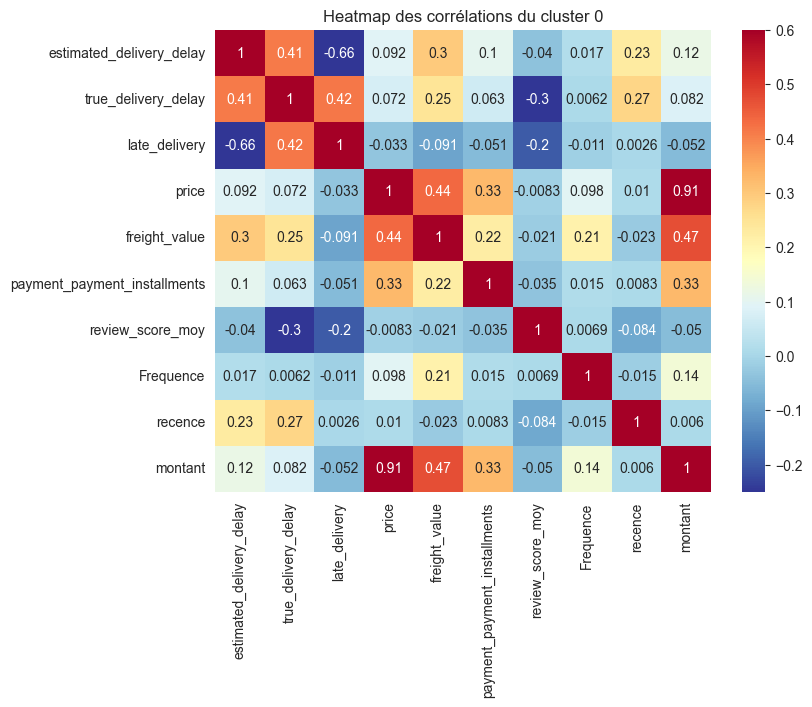

In [28]:
#  Corrélation entre le cluster 0 et le dataframe data_fe_client
plt.figure(figsize = (8, 6))

data_corr = df_cluster_0.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 0');

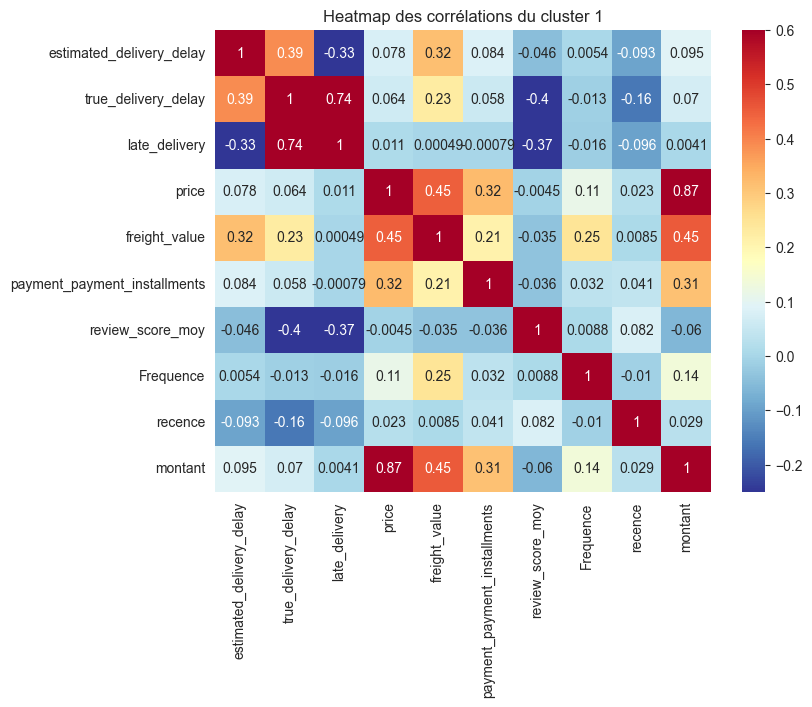

In [29]:
#  Corrélation entre le cluster 1 et le dataframe data_fe_client
plt.figure(figsize = (8, 6))

data_corr = df_cluster_1.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 1');

Text(0.5, 1.0, 'Heatmap des corrélations du cluster 2')

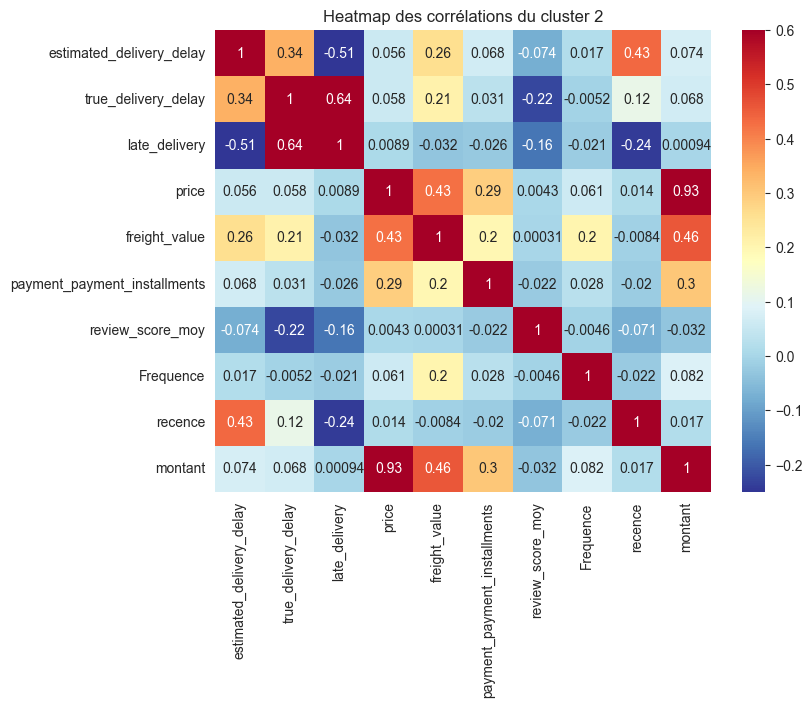

In [30]:
#  Corrélation entre le cluster 2 et le dataframe data_fe_client
plt.figure(figsize = (8, 6))

data_corr = df_cluster_2.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 2')

Les corrélations sont proches entre les 3 clusters.

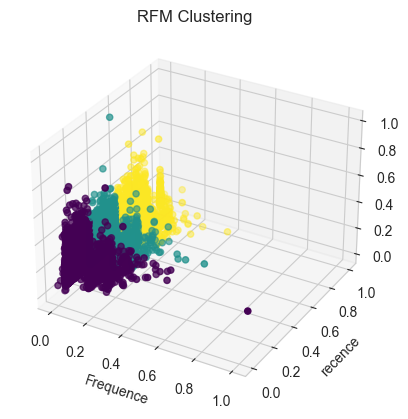

In [31]:
# Visualisation des résultats en 3D
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(data_rfm_norm['Frequence'],data_rfm_norm['recence'],data_rfm_norm['montant'],c=data_rfm_norm['cluster'],cmap='viridis')
ax.set_xlabel('Frequence')
ax.set_ylabel('recence')
ax.set_zlabel('montant')
ax.set_title('RFM Clustering')
plt.show()

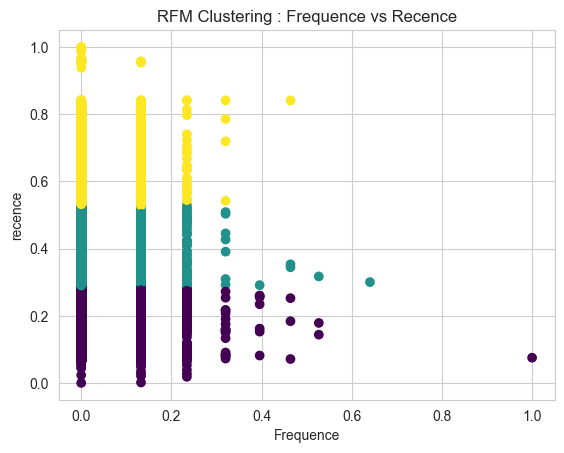

In [32]:
# Visualisation des résultats en 2D
plt.scatter(data_rfm_norm['Frequence'],data_rfm_norm['recence'],c=data_rfm_norm['cluster'],cmap='viridis')
plt.xlabel('Frequence')
plt.ylabel('recence')
plt.title('RFM Clustering : Frequence vs Recence')
plt.show()

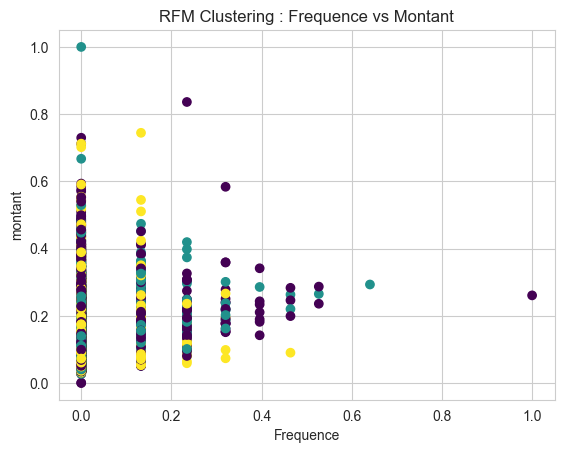

In [33]:
# Visualisation des résultats en 2D
plt.scatter(data_rfm_norm['Frequence'],data_rfm_norm['montant'],c=data_rfm_norm['cluster'],cmap='viridis')
plt.xlabel('Frequence')
plt.ylabel('montant')
plt.title('RFM Clustering : Frequence vs Montant')
plt.show()

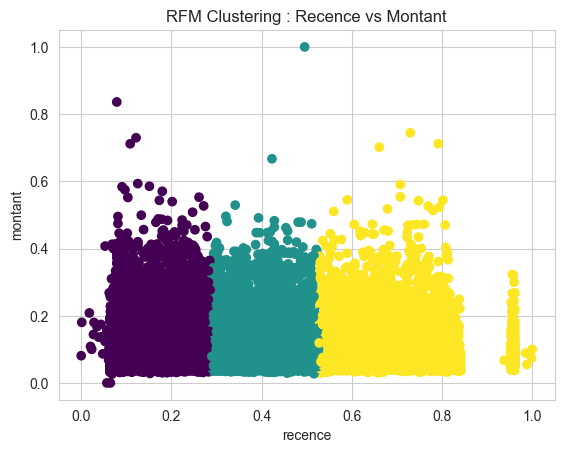

In [34]:
# Visualisation des résultats en 2D
plt.scatter(data_rfm_norm['recence'],data_rfm_norm['montant'],c=data_rfm_norm['cluster'],cmap='viridis')
plt.xlabel('recence')
plt.ylabel('montant')
plt.title('RFM Clustering : Recence vs Montant')
plt.show()

Traçons les graphiques radars :

In [35]:
data_fe_cluster.drop('customer_unique_id', axis=1, inplace=True)
data_fe_cluster

estimated_delivery_delay  true_delivery_delay  late_delivery   price  \
0                          11.0                  6.0           -5.0  129.90   
1                           8.0                  3.0           -5.0   18.90   
2                          28.0                 26.0           -2.0   69.00   
3                          32.0                 20.0          -12.0   25.99   
4                          21.0                 13.0           -8.0  180.00   
...                         ...                  ...            ...     ...   
96091                      55.0                 28.0          -27.0  680.00   
96092                      33.0                 30.0           -3.0   64.89   
96093                      45.0                 15.0          -30.0   89.90   
96094                      26.0                 12.0          -14.0  115.00   
96095                      24.0                  8.0          -16.0   56.99   

       freight_value  payment_payment_installments  review_score_moy  \
0              12.00                           8.0               5.0   
1               8.29                           1.0               4.0   
2              17.22                           8.0               3.0   
3              17.63                           4.0               4.0   
4              16.89                           6.0               5.0   
...              ...                           ...               ...   
96091         239.14                          10.0               5.0   
96092          19.69                           1.0               4.0   
96093          22.56                           1.0               5.0   
96094          18.69                           5.0               5.0   
96095          14.57                           4.0               5.0   

       Frequence  recence  montant  cluster  
0              1    160.0   141.90        0  
1              1    163.0    27.19        0  
2              1    586.0    86.22        2  
3              1    370.0    43.62        1  
4              1    337.0   196.89        1  
...          ...      ...      ...      ...  
96091          1    496.0  2067.42        2  
96092          1    311.0    84.58        1  
96093          1    617.0   112.46        2  
96094          1    168.0   133.69        0  
96095          1    533.0    71.56        2  

[96096 rows x 11 columns]

In [36]:
features = data_fe_cluster.columns[:-1]
data_fe_cluster_means = data_fe_cluster.groupby('cluster')[features].mean()
data_fe_cluster_means

estimated_delivery_delay  true_delivery_delay  late_delivery  \
cluster                                                                 
0                       22.456830            10.474279     -12.012823   
1                       25.083183            14.710129     -10.385926   
2                       26.429495            12.310194     -13.975372   

              price  freight_value  payment_payment_installments  \
cluster                                                            
0        132.636645      21.968586                      2.801768   
1        125.394563      20.030951                      2.855581   
2        129.926073      19.781444                      3.145352   

         review_score_moy  Frequence     recence     montant  
cluster                                                       
0                4.177315   1.039288  136.524302  171.314611  
1                3.965606   1.034828  305.319176  162.163252  
2                4.125305   1.027428  509.028004  166.013254

In [37]:
scaler = MinMaxScaler()
data_fe_cluster[features] = scaler.fit_transform(data_fe_cluster[features])
cluster_means = data_fe_cluster.groupby('cluster')[features].mean()
cluster_means

estimated_delivery_delay  true_delivery_delay  late_delivery  \
cluster                                                                 
0                        0.132837             0.049878       0.402947   
1                        0.149891             0.070048       0.407803   
2                        0.158633             0.058620       0.397088   

            price  freight_value  payment_payment_installments  \
cluster                                                          
0        0.017953       0.053624                      0.116740   
1        0.016973       0.048894                      0.118983   
2        0.017586       0.048285                      0.131056   

         review_score_moy  Frequence   recence   montant  
cluster                                                   
0                0.794329   0.002456  0.176616  0.012538  
1                0.741402   0.002177  0.394980  0.011868  
2                0.781326   0.001714  0.658510  0.012150

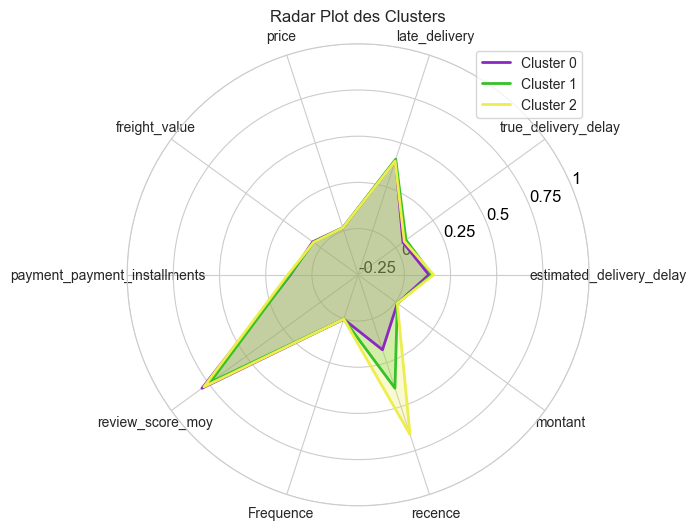

In [38]:
features = data_fe_cluster.columns[:-1]

# Normalisation des colonnes de ces données
scaler = MinMaxScaler()
data_fe_cluster[features] = scaler.fit_transform(data_fe_cluster[features])

# Calcul des moyennes des nouvelles variables pour chaque cluster
cluster_means = data_fe_cluster.groupby('cluster')[features].mean()

# Calcul des angles pour le graphique en toile d'araignée
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

# Création de la figure et du sous-graphique
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})
cluster_colors = ['#8b28c1','#36c128','#EDED4E']

# Tracer chaque cluster
for i in range(3):
    values = cluster_means.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}", color=cluster_colors[i])

# Remplissage des zones à l'intérieur du polygone pour chaque cluster
ax.fill(angles, cluster_means.iloc[0].tolist() + [cluster_means.iloc[0, 0]], alpha=0.25, color=cluster_colors[0])
ax.fill(angles, cluster_means.iloc[1].tolist() + [cluster_means.iloc[1, 0]], alpha=0.25, color=cluster_colors[1])
ax.fill(angles, cluster_means.iloc[2].tolist() + [cluster_means.iloc[2, 0]], alpha=0.25, color=cluster_colors[2])

# Étiquettes des axes et légendes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
ax.set_title("Radar Plot des Clusters")
ax.set_yticks([-0.25, 0, 0.25,0.5,0.75, 1],
                   ["-0.25", "0", "0.25","0.5","0.75", "1"],
                   color="black",
                   size=12)
ax.set_ylim(-0.25, 1)
ax.legend()

plt.show()

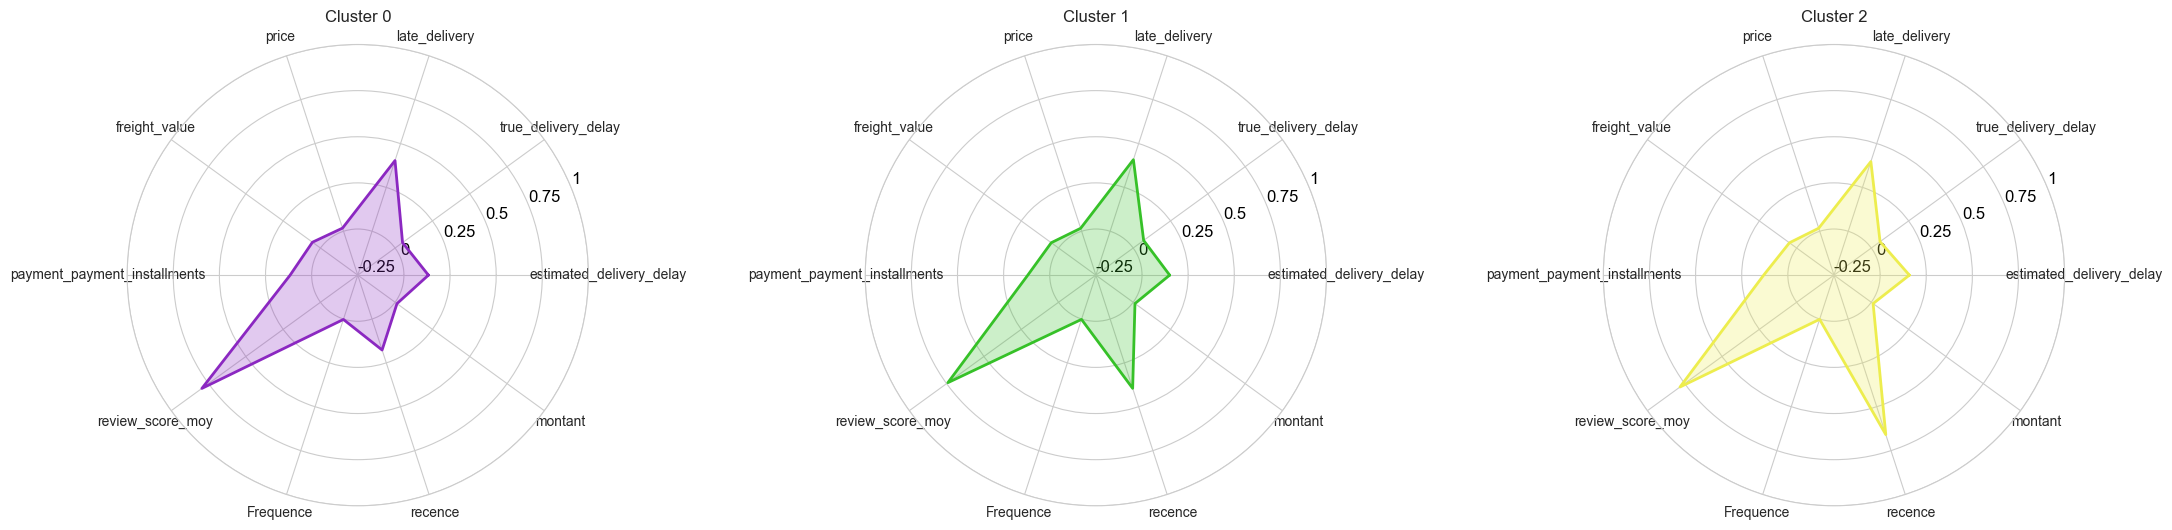

In [39]:
# Liste de toutes les variables que vous souhaitez inclure dans le radar plot
features = data_fe_cluster.columns[:-1]

# Normalisation des colonnes de ces données
scaler = MinMaxScaler()
data_fe_cluster[features] = scaler.fit_transform(data_fe_cluster[features])

# Calcul des moyennes des nouvelles variables pour chaque cluster
# Assurez-vous que les nouvelles variables sont présentes dans data_rfm_norm
cluster_means = data_fe_cluster.groupby('cluster')[features].mean()

# Calcul des angles pour le graphique en toile d'araignée
angles = [n / float(len(features)) * 2 * np.pi for n in range(len(features))]
angles += angles[:1]

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1,3,figsize=(25, 8), subplot_kw={'polar': True})
cluster_colors = ['#8b28c1','#36c128','#EDED4E']
plt.subplots_adjust(wspace=0.6)

# Tracer chaque cluster
for i in range(3):
  ax=axes[i]
  values = cluster_means.iloc[i].tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}", color=cluster_colors[i])
  ax.fill(angles, values, alpha=0.25, facecolor=cluster_colors[i])

# étiquettes des axes et légende
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(features)
  ax.set_title(f"Cluster {i}")
  ax.set_yticks([-0.25, 0, 0.25,0.5,0.75, 1],
                   ["-0.25", "0", "0.25","0.5","0.75", "1"],
                   color="black",
                   size=12)
  ax.set_ylim(-0.25, 1)

plt.show()


Le clustering RFM avec l'algorithme du kmeans définit 3 clusters avec peu de différences puisque la séparation n'est effectué que sur la récence :
- les clients qui ont commandés récemment (violet). Cela correspond plutôt à des clients "nouveaux" pour l'entreprise.
- les clients qui ont commandés moins récemment (vert). Cela correspond plutôt à des clients "à contacter pour fidélisation" pour l'entreprise.
- les clients qui ont commandés anciennement (jaune) . On pourrait catégoriser ces clients comme "anciens/perdus".

In [40]:
# Calcul de la répartition des clusters
data_cluster =data_rfm_norm.groupby('cluster', dropna=False)['recence'].count()
print(data_cluster)

cluster
0    37034
1    36494
2    22568
Name: recence, dtype: int64


Text(0.5, 1.0, 'Proportion des clusters dans la population')

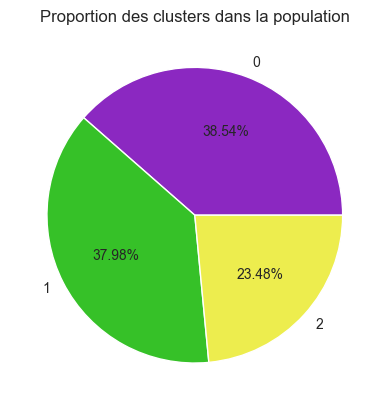

In [41]:

labels = ['0','1','2']
colors = ['#8b28c1','#36c128','#EDED4E']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_cluster, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des clusters dans la population")

La proportion des clients dans chaque cluster est assez équivalent avec 23% de clients "anciens" (jaune) et 39% de clients "nouveaux" (violet).

In [42]:
# Calcul de la répartition des clusters
data_fr =data_rfm_cluster.groupby('Frequence', dropna=False)['recence'].count()
print(data_fr)

Frequence
1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: recence, dtype: int64


Text(0.5, 1.0, 'Proportion des client dans la population en fonction leur fréquence ')

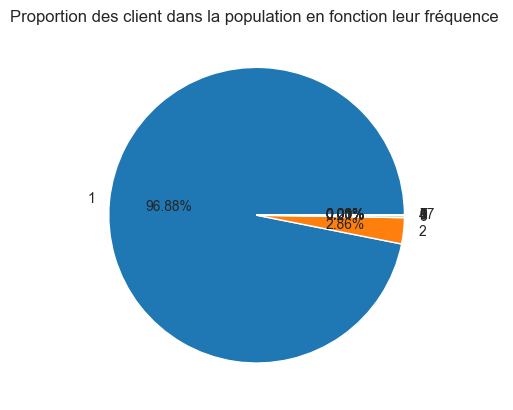

In [43]:
labels = data_rfm_cluster['Frequence'].unique()
colors = ['#8b28c1','#36c128','#EDED4E']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_fr, labels=labels,autopct='%.2f%%')
plt.title("Proportion des client dans la population en fonction leur fréquence ")

On voit qu'environ 97% de la population a une fréquence égale à 1 et n'a donc fait qu'un seul achat. Cette variable n'est pas très pertinente pour le clustering.

Cherchons maintenant le nombre optimal de clusters.

#### Optimisation du nombre de clusters avec la méthode du coude

Pour cette méthode, on trace la somme des carrés des distances intra-cluster (ou SSE) en foncion du nombre de cluster. Le nombre de cluster optimal est le point où la courbe commence à se stabiliser.

In [44]:
data_rfm_norm=data_rfm_norm.drop(['cluster'], axis=1)
data_rfm_norm

Frequence   recence   montant
0            0.0  0.206986  0.101906
1            0.0  0.210867  0.044608
2            0.0  0.758085  0.079435
3            0.0  0.478655  0.056501
4            0.0  0.435964  0.120039
...          ...       ...       ...
96091        0.0  0.641656  0.388977
96092        0.0  0.402329  0.078676
96093        0.0  0.798189  0.090721
96094        0.0  0.217335  0.098914
96095        0.0  0.689521  0.072368

[96096 rows x 3 columns]

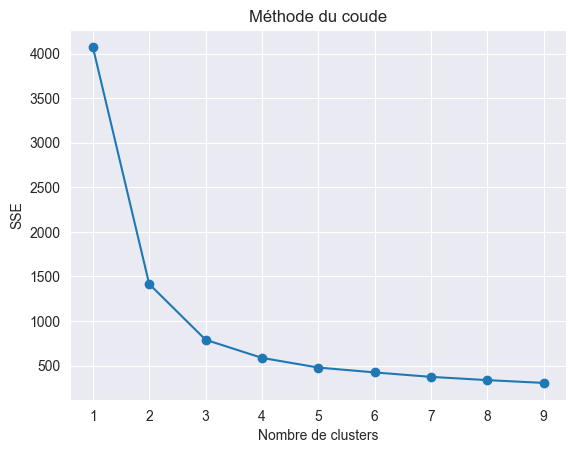

In [45]:
SSE=[]
for i in range(1,10):
    kmeans_sse=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sse.fit(data_rfm_norm)
    SSE.append(kmeans_sse.inertia_)

# Visualisation de la courbe de la méthode du coude
plt.plot(range(1,10),SSE,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.title('Méthode du coude')
plt.show()

#### Optimisation du nombre de clusters avec la méthode de la silhouette

Cette méthode mesure si chaque point est bien regroupé au sein de son propre cluster par rapport aux autres clusters. Il varie de -1 (mal regroupés) à 1 (bien regroupés).

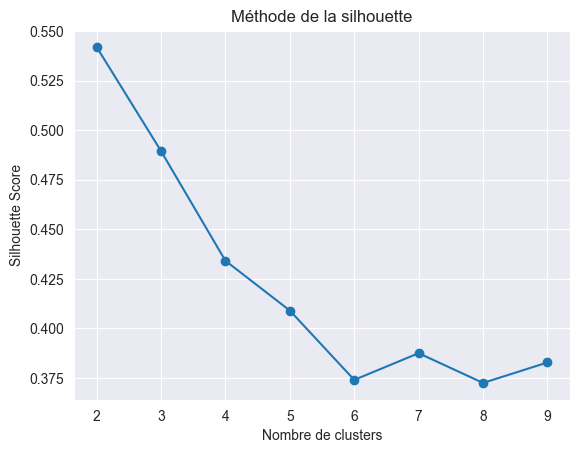

In [46]:
sil=[]
for i in range(2,10):
    kmeans_sil=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sil.fit(data_rfm_norm)
    labels = kmeans_sil.labels_
    sil.append(silhouette_score(data_rfm_norm,labels))

plt.plot(range(2,10),sil,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la silhouette')
plt.show()

#### Optimisation du nombre de clusters avec la méthode de Davies-Bouldin

Plus l'indice est bas, meilleure est la séparation entre les clusters.

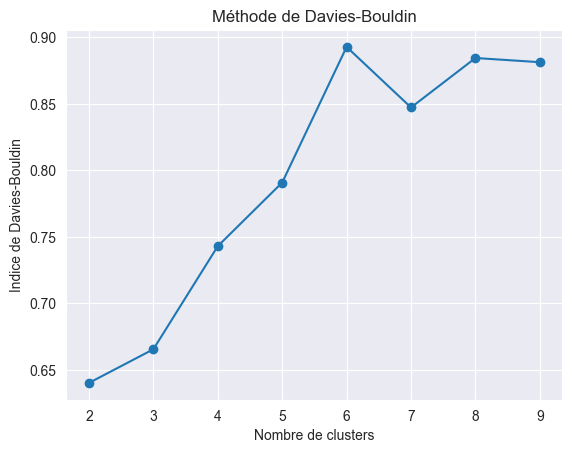

In [47]:
db=[]
for i in range(2,10):
    kmeans_db=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    clusters=kmeans_db.fit_predict(data_rfm_norm)
    db.append(davies_bouldin_score(data_rfm_norm,clusters))

plt.plot(range(2,10),db,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de Davies-Bouldin')
plt.title('Méthode de Davies-Bouldin')
plt.show()

In [48]:
# Standard Scaler des données RFM initiales (après racine carrée) pour la PCA
features = data_rfm_sqrt.columns
scaler = StandardScaler()
data_rfm_sqrt[features] = pd.DataFrame(scaler.fit_transform(data_rfm_sqrt[features]))
data_rfm_sqrt

Frequence   recence   montant
0      -0.171727 -0.835036  0.054773
1      -0.171727 -0.815482 -1.129665
2      -0.171727  1.941708 -0.409735
3      -0.171727  0.533782 -0.883832
4      -0.171727  0.318682  0.429600
...          ...       ...       ...
96091  -0.171727  1.355072  5.988962
96092  -0.171727  0.149209 -0.425427
96093  -0.171727  2.143772 -0.176439
96094  -0.171727 -0.782891 -0.007075
96095  -0.171727  1.596245 -0.555833

[96096 rows x 3 columns]

Pour n_clusters = 2 Le score de silhouette moyen est de: 0.5420070798534113
Pour n_clusters = 3 Le score de silhouette moyen est de: 0.4894963413815884
Pour n_clusters = 4 Le score de silhouette moyen est de: 0.4341258963057469


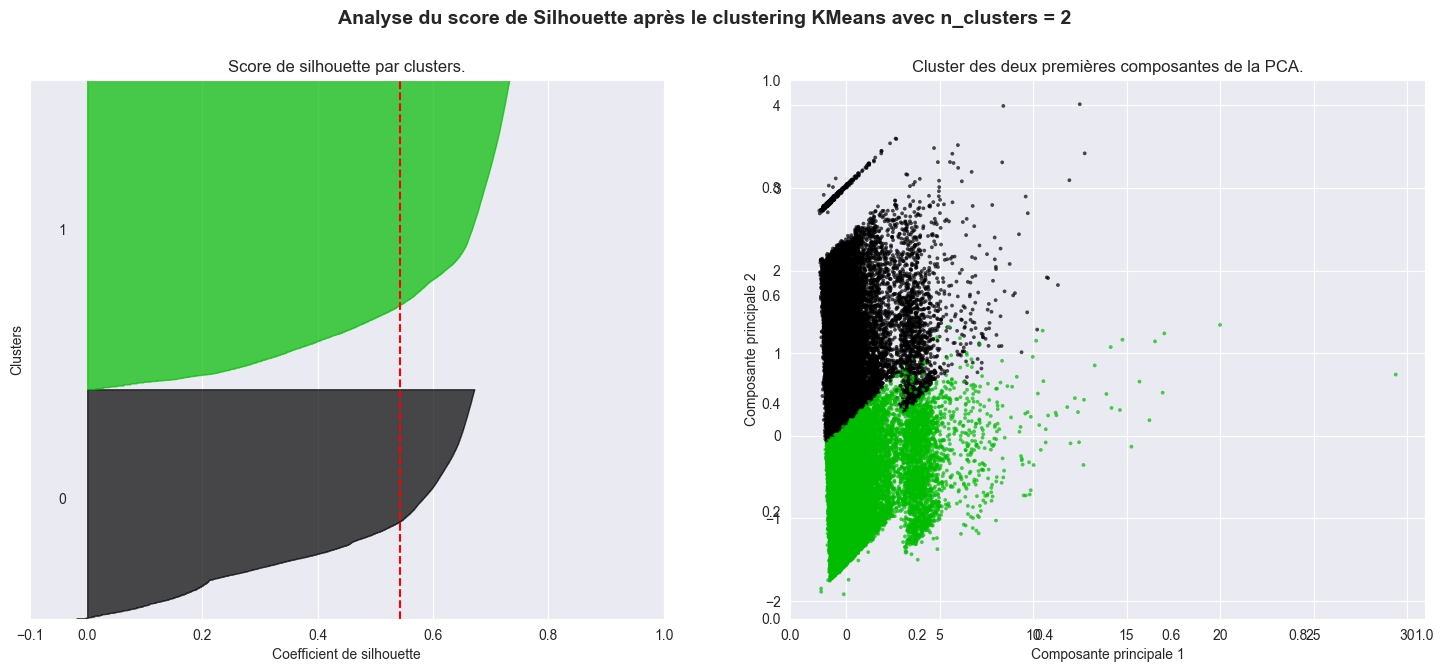

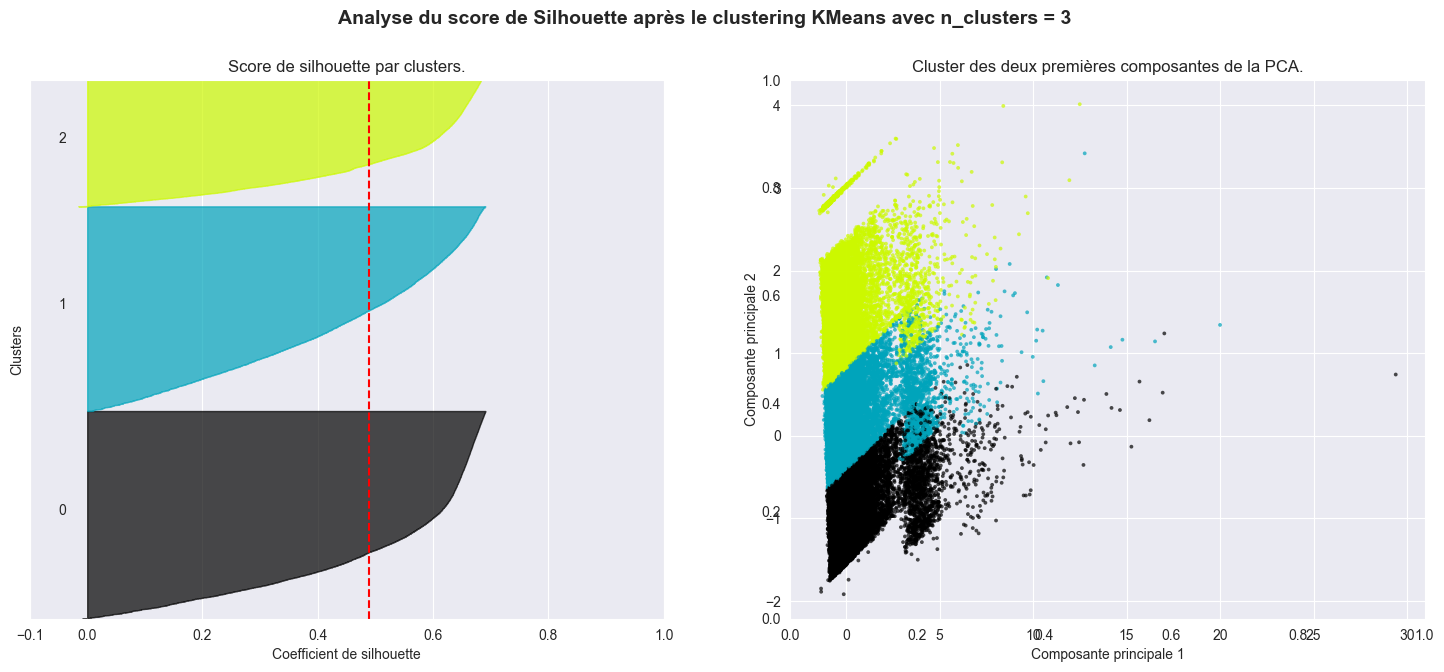

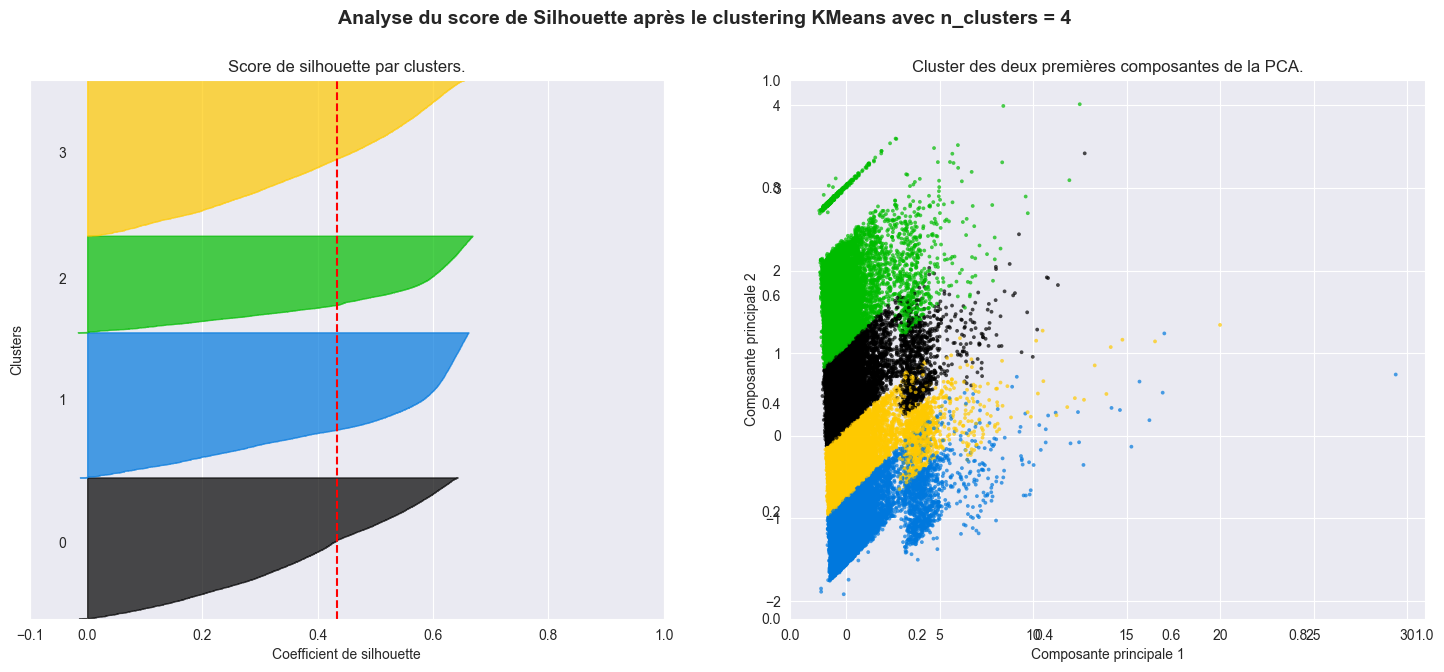

In [49]:
range_n_clusters = [2, 3, 4]


for n_clusters in range_n_clusters:
    # Creation des graphiques 1 lignes, 3 colonnes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Premier graphique : score de silhouette par cluster
    # Le coefficient de silhouette peut aller de -1, 1 mais on le fera de [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    #  (n_clusters+1)*10 pour insérer un espace pour démarquer les clusters
    ax1.set_ylim([0, len(data_rfm_norm) + (n_clusters + 1) * 10])

    # Clustering
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=300,random_state=42)
    cluster_labels = clusterer.fit_predict(data_rfm_norm)

    # Calcul des scores de silhouette
    silhouette_avg = silhouette_score(data_rfm_norm, cluster_labels)
    print(
        "Pour n_clusters =",
        n_clusters,
        "Le score de silhouette moyen est de:",
        silhouette_avg,
    )

    # Calcul du score de silhouette pour chaque échantillon
    sample_silhouette_values = silhouette_samples(data_rfm_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Titre du graphiques et étiquettes
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Score de silhouette par clusters.")
    ax1.set_xlabel("Coefficient de silhouette")
    ax1.set_ylabel("Clusters")

    # Ligne verticale pour le score de silhouette moyen
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Deuxième graphique : clusters formés selon les deux premières variables "fréquence" et "recence"

    # PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_rfm_sqrt)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(data_pca[:, 0],data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax2.set_title("Cluster des deux premières composantes de la PCA.")
    ax2.set_xlabel("Composante principale 1")
    ax2.set_ylabel("Composante principale 2")

    plt.suptitle(
        "Analyse du score de Silhouette après le clustering KMeans avec n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Peu importe le nombre de cluster, le schéma de séparation reste le même et est donc basé sur la récence uniquement ce qui n'est pas suffisant en terme d'explicabilité métier.

#### Evaluation

In [50]:
# on veut des distances intraclusters (c'est l'homogénéité) faibles et des distances interclusters (la séparation) grandes.
# cela correspond à un silhouette score égal à 1, un score de Davies Bouldin bas et un score Calinsky Harabasz élevé.
sil_score=silhouette_score(data_rfm_norm,kmeans.labels_)
db_score=davies_bouldin_score(data_rfm_norm,kmeans.labels_)
ch_score=calinski_harabasz_score(data_rfm_norm,kmeans.labels_)

print(f"Le score de silhouette est de : {sil_score}")
print(f"Le score de Davies-Bouldin est de : {db_score}")
print(f"Le score de Calinsky-Harabasz est de : {ch_score}")

Le score de silhouette est de : 0.4894963413815884
Le score de Davies-Bouldin est de : 0.6654764313446463
Le score de Calinsky-Harabasz est de : 199866.7296070196


Le score de silhouette est moyen et ces scores vont nous servir de base pour comparer.

Testons la stabilité du clustering :

In [51]:
n_runs=10
labels_list=[]
labels_list.append(kmeans.labels_)
data_rfm_norm.drop(data_rfm_norm.columns[-1], axis=1, inplace=True)
# Différente initialisation du k-means
for i in range(n_runs):
  kmeans_ari=KMeans(init='k-means++',n_clusters=3,n_init=10,max_iter=300, random_state=42+i*10)
  kmeans_ari.fit(data_rfm_norm)
  labels_list.append(kmeans_ari.labels_)
# Calcul de l'ARI entre les paires de labels
ari_score=[]
for i in range(n_runs+1):
    for j in range(i+1, n_runs+1):
      ari = adjusted_rand_score(labels_list[i], labels_list[j])
      ari_score.append(ari)
print(f"Le score moyen de l'ARI est de :", np.mean(ari_score))
print(f"L'écart-type de l'ARI est de :", np.std(ari_score))


Le score moyen de l'ARI est de : 0.9909418788373848
L'écart-type de l'ARI est de : 0.007005386683391099


Le score ARI est compris entre 0 (aléatoire) et 1 (parfaite concordance). Ici, nous avons donc une excellente stabilité de notre clustering.

#### Conclusion

Notre clustering est stable mais les variables choisies peuvent être optimisées les clusters ne sont pas vraiment bien séparés et l'explicabilité métier est peu pertinente.

La récence n'étant basé que sur une date (celle du dernier achat), cette variable risque de ne pas rendre l'algorithme de clustering très stable dans le temps.

De même, seul 3% de la population a une fréquence supérieure à 1 donc cette variable est peu pertinente pour le clustering.

Retirons-les et ajoutons de nouvelles variables pertinentes.

## Clustering n°2 (Montant-Frais de livraison-Satisfaction-Retard de livraison-Echelonnage de paiement) :



In [52]:
data_fe_client.describe()

order_id  estimated_delivery_delay  true_delivery_delay  \
count  96096.000000              96096.000000         93356.000000   
mean       1.034809                 24.387204            12.507146   
std        0.214384                  8.780618             9.555496   
min        1.000000                  2.000000             0.000000   
25%        1.000000                 19.000000             7.000000   
50%        1.000000                 24.000000            10.000000   
75%        1.000000                 29.000000            16.000000   
max       17.000000                156.000000           210.000000   

       late_delivery         price  freight_value  payment_total  \
count   93356.000000  96096.000000   96096.000000   96096.000000   
mean      -11.849300    129.249774      20.719091     166.592492   
std        10.140626    196.690366      16.704279     231.428332   
min      -147.000000      0.000000       0.000000       0.000000   
25%       -17.000000     42.000000      13.370000      63.120000   
50%       -12.000000     79.900000      16.600000     108.000000   
75%        -7.000000    144.000000      22.110000     183.530000   
max       188.000000   7388.000000     409.680000   13664.080000   

       payment_payment_installments  review_score_moy  
count                  96095.000000      95380.000000  
mean                       2.902892          4.084811  
std                        2.687117          1.341711  
min                        0.000000          1.000000  
25%                        1.000000          4.000000  
50%                        2.000000          5.000000  
75%                        4.000000          5.000000  
max                       24.000000          5.000000

In [53]:
data_cluster2=data_fe_client[['freight_value','payment_total','review_score_moy','late_delivery','payment_payment_installments']]
data_cluster2 = data_cluster2.rename(columns={
                            "payment_total": "montant_total",
                            "freight_value": "frais_livraison",
                            "review_score_moy": "satisfaction",
                            "late_delivery": "retard_livraison",
                            "payment_payment_installments": "nb_versement"})
data_cluster2

frais_livraison  montant_total  satisfaction  retard_livraison  \
0                12.00         141.90           5.0              -5.0   
1                 8.29          27.19           4.0              -5.0   
2                17.22          86.22           3.0              -2.0   
3                17.63          43.62           4.0             -12.0   
4                16.89         196.89           5.0              -8.0   
...                ...            ...           ...               ...   
96091           239.14        2067.42           5.0             -27.0   
96092            19.69          84.58           4.0              -3.0   
96093            22.56         112.46           5.0             -30.0   
96094            18.69         133.69           5.0             -14.0   
96095            14.57          71.56           5.0             -16.0   

       nb_versement  
0               8.0  
1               1.0  
2               8.0  
3               4.0  
4               6.0  
...             ...  
96091          10.0  
96092           1.0  
96093           1.0  
96094           5.0  
96095           4.0  

[96096 rows x 5 columns]

### Analyse des variables :

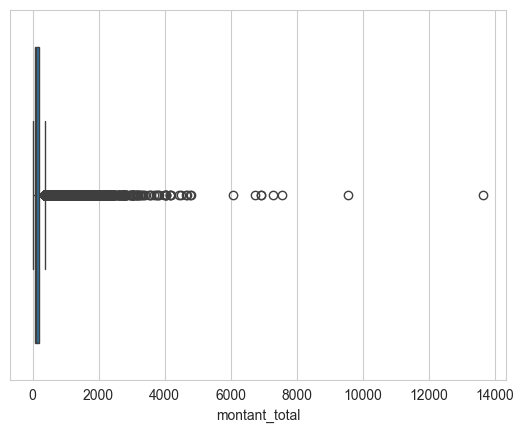

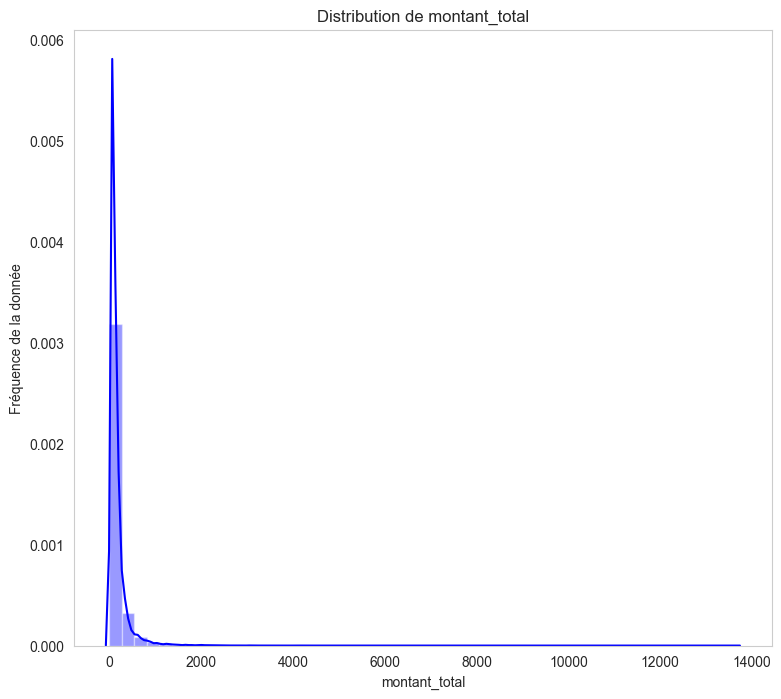

In [54]:
describe_data_quant(data_cluster2, 'montant_total')

La variable "montant_total" a une variance qui pourra potentiellement être utile pour le clustering.

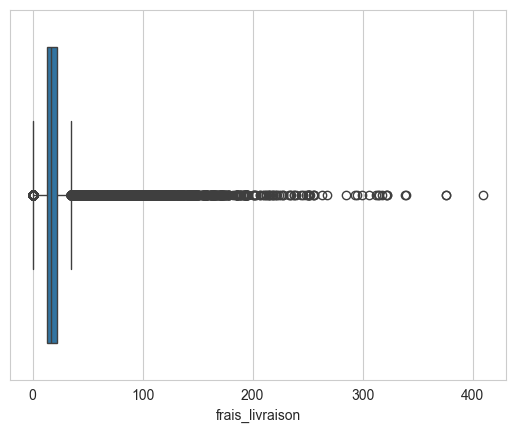

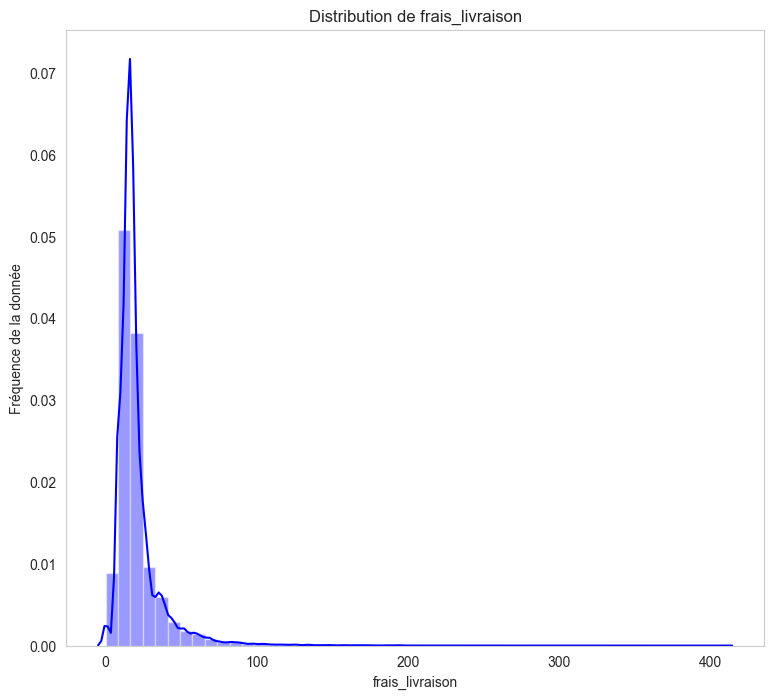

In [55]:
describe_data_quant(data_cluster2, 'frais_livraison')

La variable "frais_livraison" a une variance qui pourra potentiellement être utile pour le clustering.

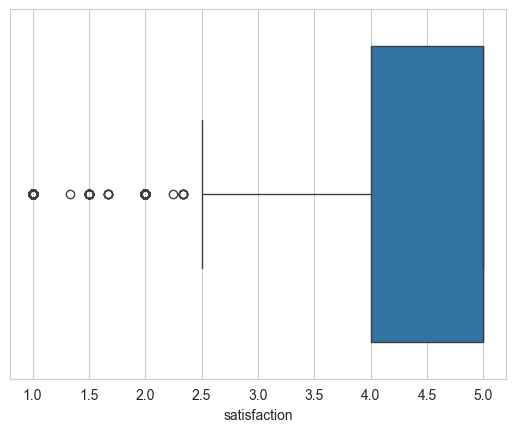

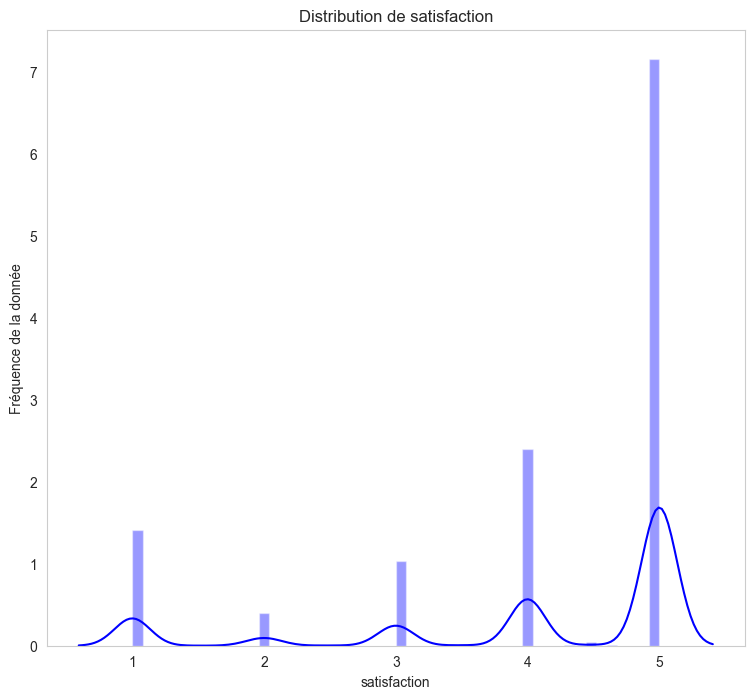

In [56]:
describe_data_quant(data_cluster2, 'satisfaction')

La variable "satisfaction" a une variance qui pourra potentiellement être utile pour le clustering.

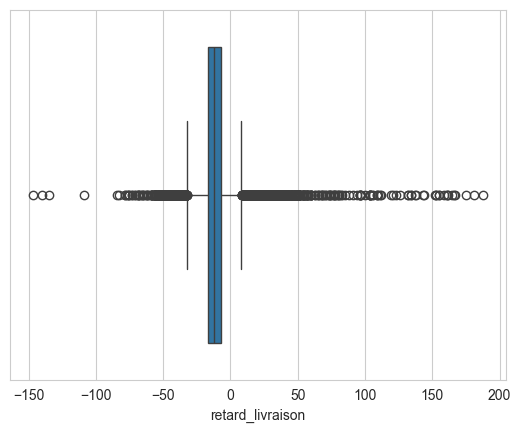

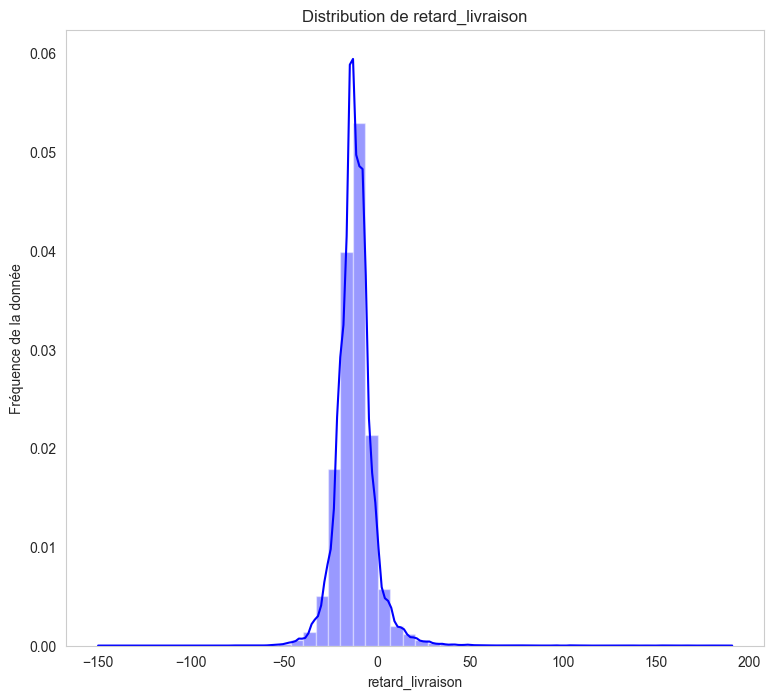

In [57]:
describe_data_quant(data_cluster2, 'retard_livraison')

La variable "retard_livraison" a une variance qui pourra potentiellement être utile pour le clustering.

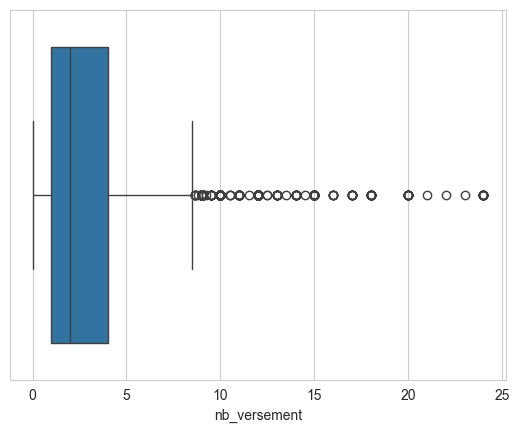

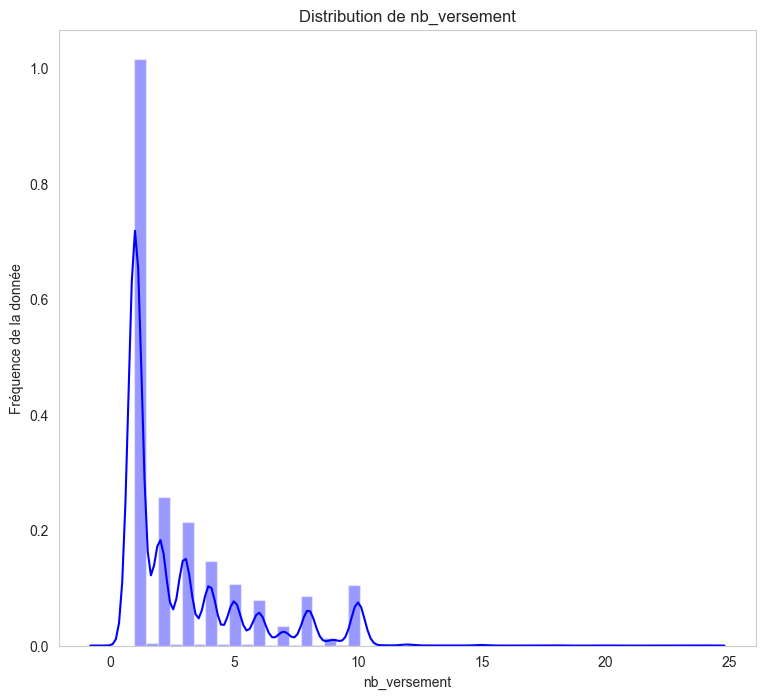

In [58]:
describe_data_quant(data_cluster2, 'nb_versement')

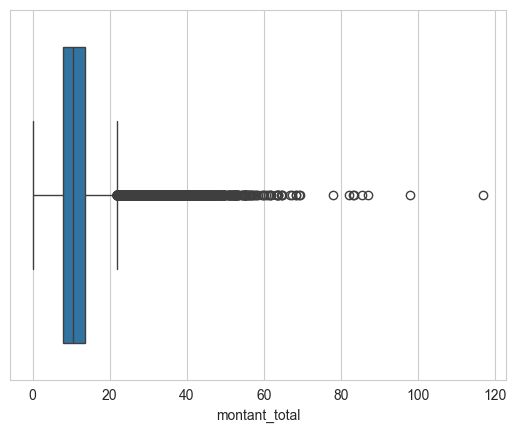

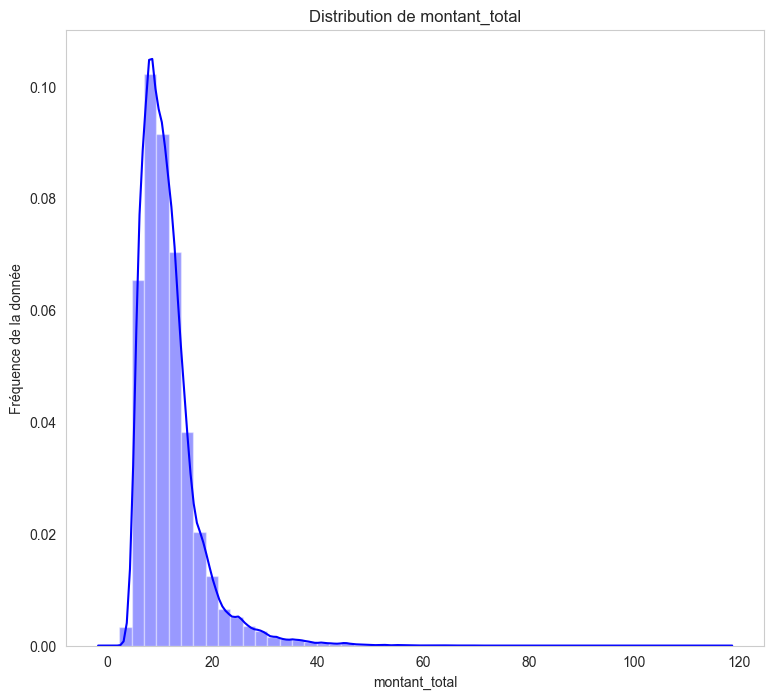

In [59]:
# Création d'un dataframe après transformation en racine carrée de certaines variables
data_cluster2_scale = pd.DataFrame()
data_cluster2_scale['montant_total']= np.sqrt(data_cluster2['montant_total'])
data_cluster2_scale['frais_livraison']= np.sqrt(data_cluster2['frais_livraison'])
data_cluster2_scale['satisfaction']= data_cluster2['satisfaction']
data_cluster2_scale['retard_livraison']= data_cluster2['retard_livraison']
data_cluster2_scale['nb_versement']= np.sqrt(data_cluster2['nb_versement'])


describe_data_quant(data_cluster2_scale, 'montant_total')

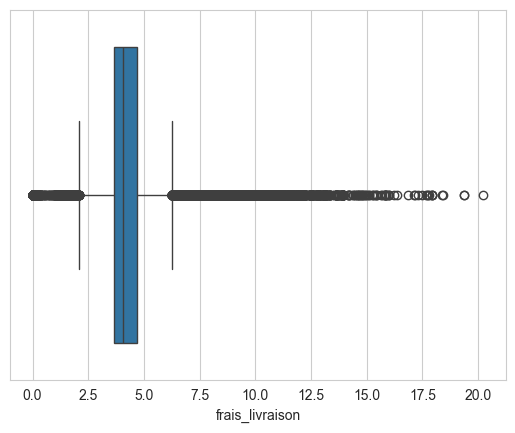

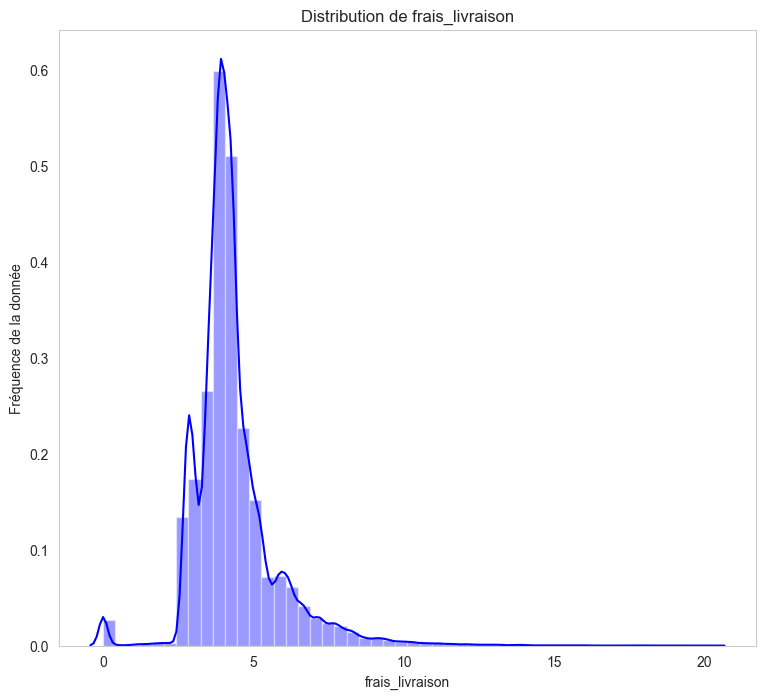

In [60]:
describe_data_quant(data_cluster2_scale, 'frais_livraison')

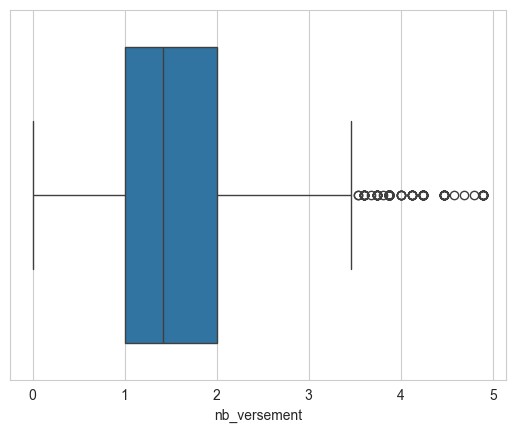

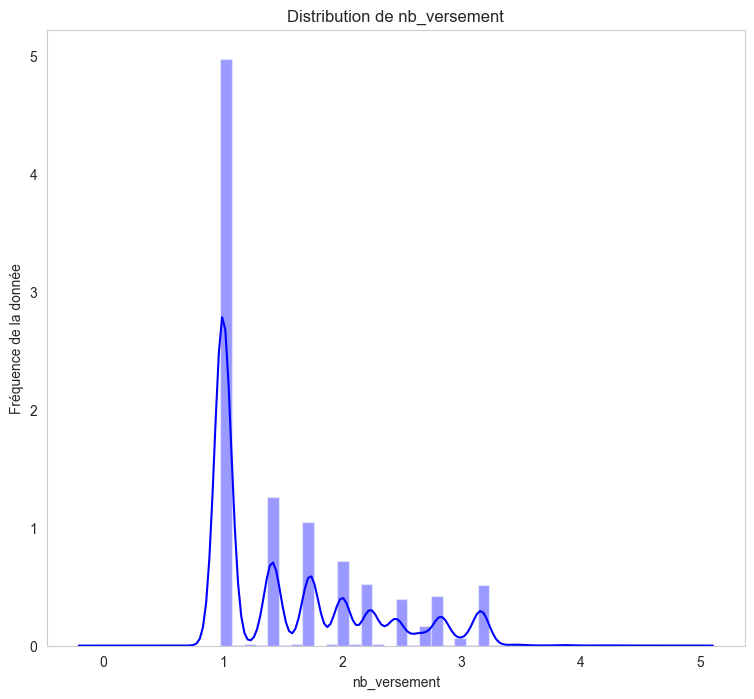

In [61]:
describe_data_quant(data_cluster2_scale, 'nb_versement')

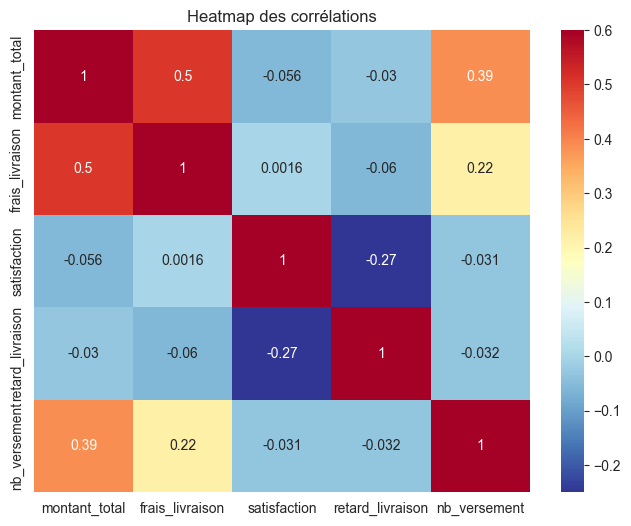

In [62]:
plt.figure(figsize = (8, 6))
data_corr = data_cluster2_scale.select_dtypes(include=['float', 'int64'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

Il n'y a pas de corrélations fortes entre les variables, ce qui est important pour le clustering.

In [63]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable
data_cluster2_scale_vm=show_miss_val(data_cluster2_scale)
data_cluster2_scale_vm.head(26)

Notre dataframe a 5 variables.
 Il y a 3 variables contenant des valeurs manquantes.


variable  miss_val
4      nb_versement  0.000010
2      satisfaction  0.007451
3  retard_livraison  0.028513

Il y a très peu de valeurs manquantes mais nous allons quand même imputer par la médiane pour que l'ensemble du jeu de données puisse être utilisé dans le clustering.

In [64]:
# Créer une instance de SimpleImputer
imputer = SimpleImputer(strategy='median')
# Remodeler la colonne en un tableau 2D
data_temp = data_cluster2_scale['nb_versement'].values.reshape(-1, 1)
data_temp_ = data_cluster2_scale['satisfaction'].values.reshape(-1, 1)
data_temp__ = data_cluster2_scale['retard_livraison'].values.reshape(-1, 1)

data_cluster2_scale['nb_versement'] = imputer.fit_transform(data_temp)
data_cluster2_scale['satisfaction'] = imputer.fit_transform(data_temp_)
data_cluster2_scale['retard_livraison'] = imputer.fit_transform(data_temp__)

data_cluster2_scale_vm=show_miss_val(data_cluster2_scale)
data_cluster2_scale_vm.head(26)

Notre dataframe a 5 variables.
 Il y a 0 variables contenant des valeurs manquantes.


Empty DataFrame
Columns: [variable, miss_val]
Index: []

Nous avons imputé toutes les valeurs manquantes par la médiane, enlevons la
colonne avec les identifiants clients et normalisons maintenant notre dataframe :

In [65]:
data_cluster2_scale.describe(include="all")

montant_total  frais_livraison  satisfaction  retard_livraison  \
count   96096.000000     96096.000000  96096.000000      96096.000000   
mean       11.602337         4.328638      4.091630        -11.853597   
std         5.654963         1.407838      1.339018          9.995040   
min         0.000000         0.000000      1.000000       -147.000000   
25%         7.944810         3.656501      4.000000        -17.000000   
50%        10.392305         4.074310      5.000000        -12.000000   
75%        13.547324         4.702127      5.000000         -7.000000   
max       116.893456        20.240553      5.000000        188.000000   

       nb_versement  
count  96096.000000  
mean       1.557863  
std        0.689891  
min        0.000000  
25%        1.000000  
50%        1.414214  
75%        2.000000  
max        4.898979

In [66]:
# Créer une instance de Scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()
# Normalisation des données
data_cluster2_scale_norm = pd.DataFrame(scaler.fit_transform(data_cluster2_scale),columns=data_cluster2_scale.columns)

data_cluster2_scale_norm.describe(include="all")

montant_total  frais_livraison  satisfaction  retard_livraison  \
count   96096.000000     96096.000000  96096.000000      96096.000000   
mean        0.099256         0.213860      0.772907          0.403422   
std         0.048377         0.069555      0.334754          0.029836   
min         0.000000         0.000000      0.000000          0.000000   
25%         0.067966         0.180652      0.750000          0.388060   
50%         0.088904         0.201294      1.000000          0.402985   
75%         0.115895         0.232312      1.000000          0.417910   
max         1.000000         1.000000      1.000000          1.000000   

       nb_versement  
count  96096.000000  
mean       0.317998  
std        0.140823  
min        0.000000  
25%        0.204124  
50%        0.288675  
75%        0.408248  
max        1.000000

### K-Means

#### Recherche du nombre de clusters avec la méthode du coude

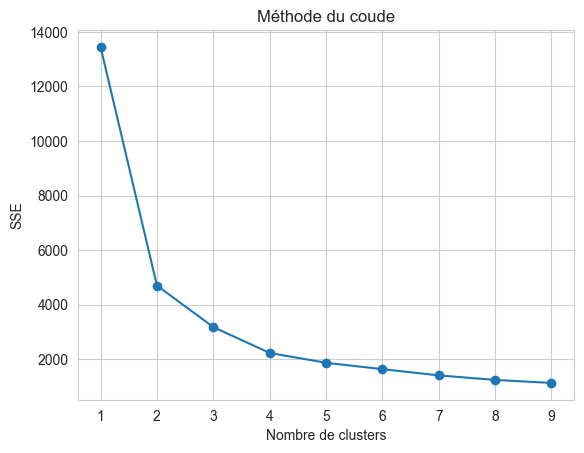

In [67]:
SSE=[]
for i in range(1,10):
    kmeans_sse=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sse.fit(data_cluster2_scale_norm)
    SSE.append(kmeans_sse.inertia_)

# Visualisation de la courbe de la méthode du coude
plt.plot(range(1,10),SSE,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.title('Méthode du coude')
plt.show()

#### Recherche du nombre de clusters avec la méthode de la silhouette



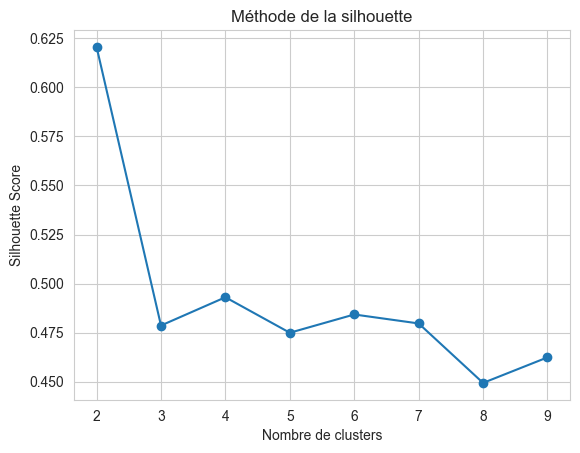

In [68]:
sil=[]
for i in range(2,10):
    kmeans_sil=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sil.fit(data_cluster2_scale_norm)
    labels = kmeans_sil.labels_
    sil.append(silhouette_score(data_cluster2_scale_norm,labels))

plt.plot(range(2,10),sil,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la silhouette')
plt.show()

#### Optimisation du nombre de clusters avec la méthode de Davies-Bouldin

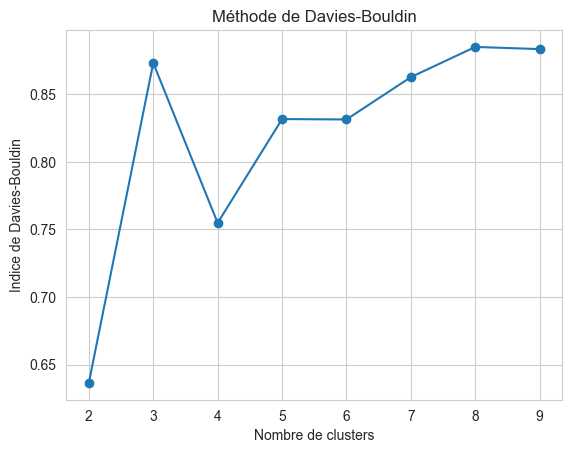

In [69]:
db=[]
for i in range(2,10):
    kmeans_db=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    clusters=kmeans_db.fit_predict(data_cluster2_scale_norm)
    db.append(davies_bouldin_score(data_cluster2_scale_norm,clusters))

plt.plot(range(2,10),db,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de Davies-Bouldin')
plt.title('Méthode de Davies-Bouldin')
plt.show()

In [70]:
# Standard Scaler des données du cluster 2 initiales (après racine carrée) pour la PCA
features = data_cluster2_scale.columns
scaler = StandardScaler()
data_cluster2_stscale=pd.DataFrame()
data_cluster2_stscale[features] = pd.DataFrame(scaler.fit_transform(data_cluster2_scale[features]))
data_cluster2_stscale

montant_total  frais_livraison  satisfaction  retard_livraison  \
0           0.054791        -0.614091      0.678389          0.685703   
1          -1.129621        -1.029528     -0.068431          0.685703   
2          -0.409707        -0.127103     -0.815251          0.985854   
3          -0.883793        -0.092219     -0.068431         -0.014648   
4           0.429609        -0.155483      0.678389          0.385553   
...              ...              ...           ...               ...   
96091       5.988851         7.909697      0.678389         -1.515400   
96092      -0.425398         0.077214     -0.068431          0.885804   
96093      -0.176416         0.299112      0.678389         -1.815550   
96094      -0.007055        -0.003867      0.678389         -0.214748   
96095      -0.555802        -0.363375      0.678389         -0.414848   

       nb_versement  
0          1.841697  
1         -0.808629  
2          1.841697  
3          0.640882  
4          1.292423  
...             ...  
96091      2.325617  
96092     -0.808629  
96093     -0.808629  
96094      0.983066  
96095      0.640882  

[96096 rows x 5 columns]

Pour n_clusters = 3 Le score de silhouette moyen est de: 0.4786575845493747
Pour n_clusters = 4 Le score de silhouette moyen est de: 0.4930583938379718
Pour n_clusters = 5 Le score de silhouette moyen est de: 0.4749707415851895
Pour n_clusters = 6 Le score de silhouette moyen est de: 0.48428153092142895


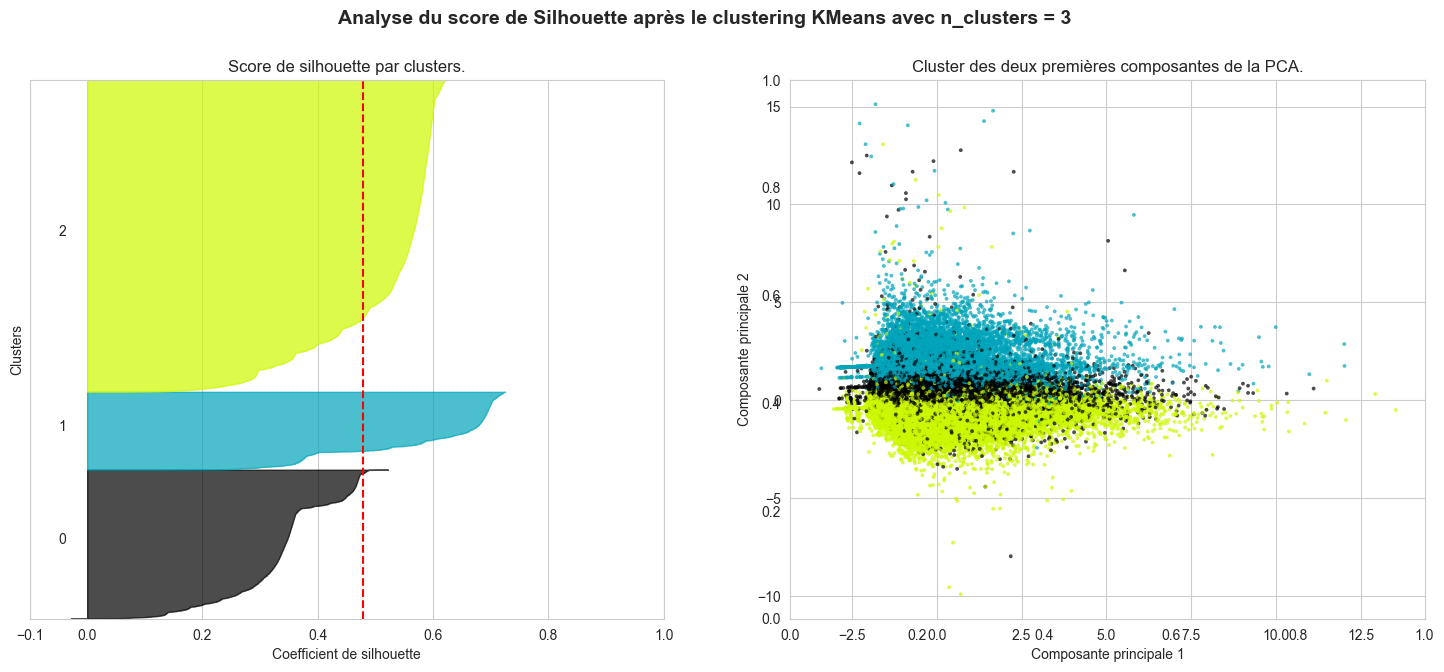

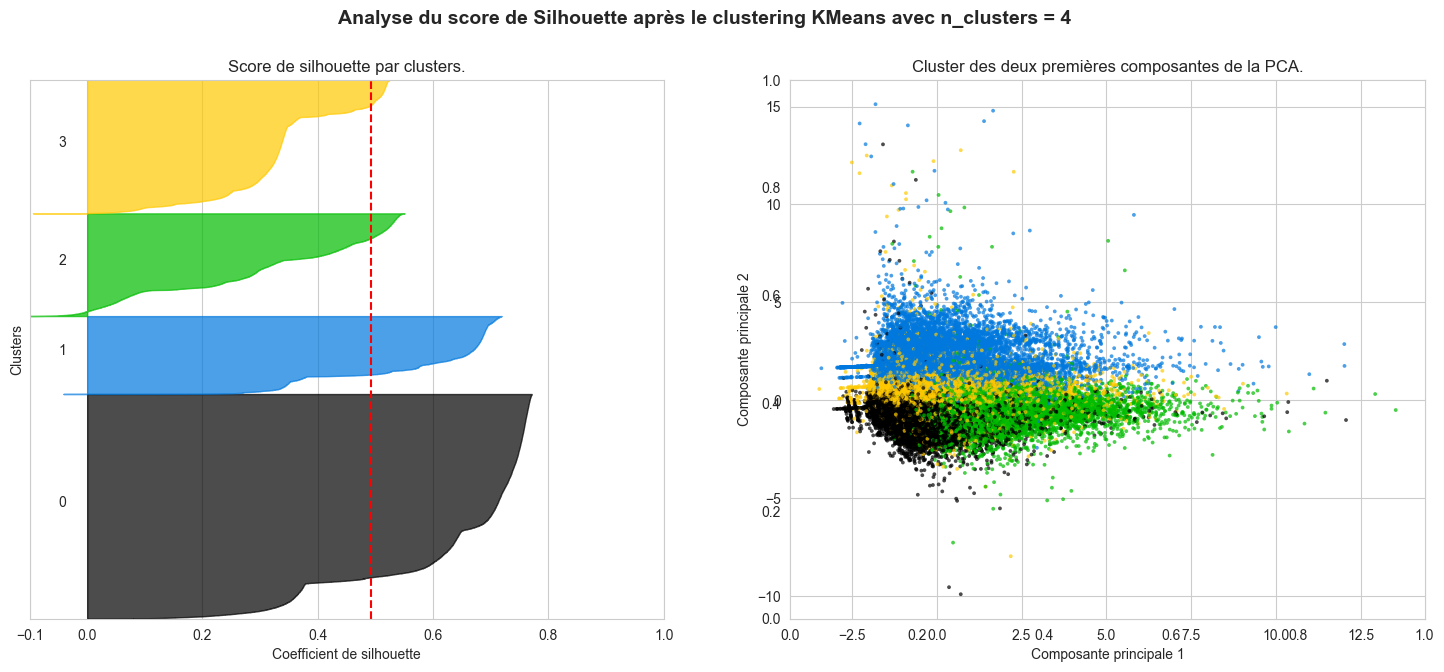

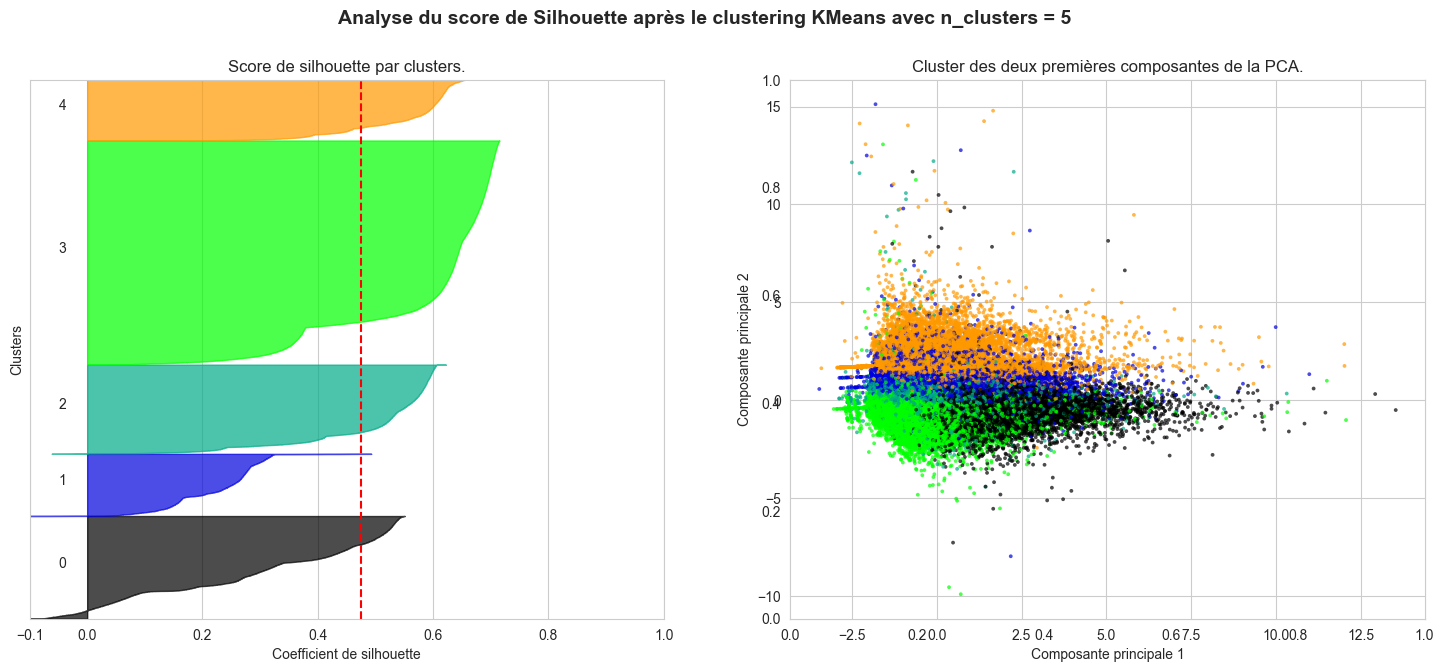

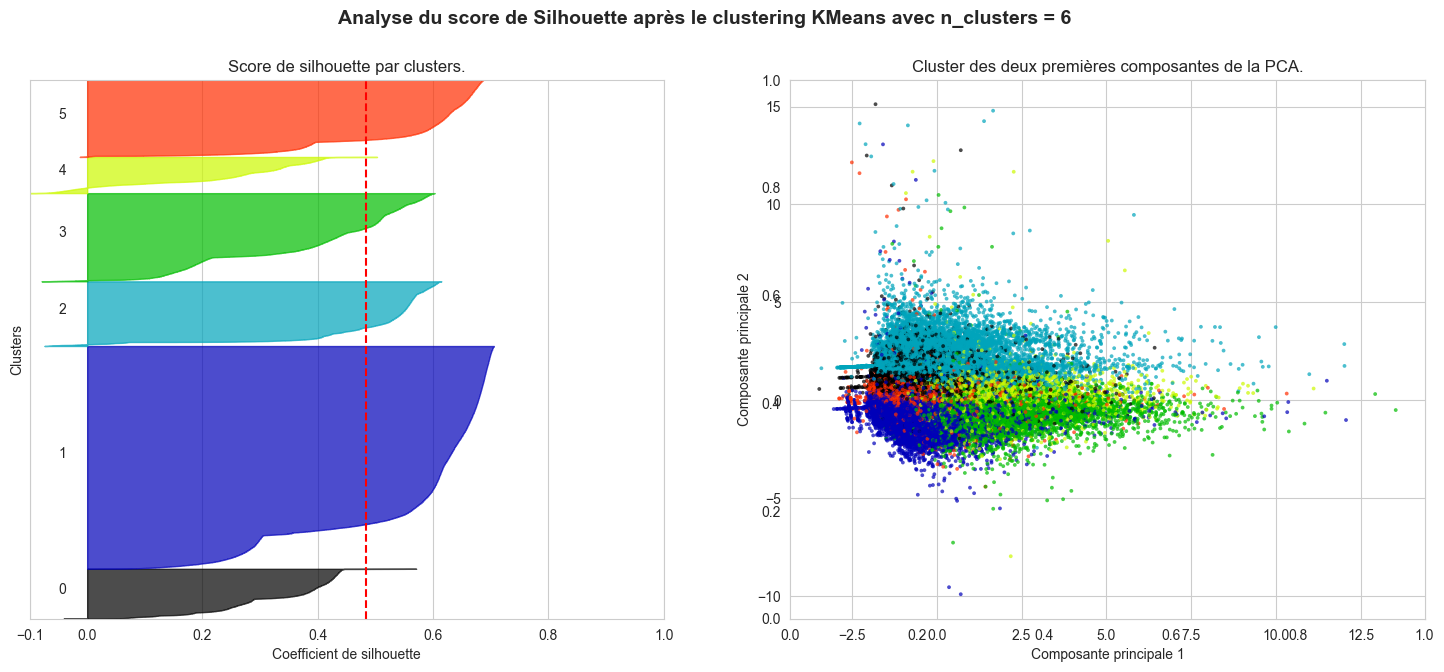

In [71]:
range_n_clusters = [3,4,5,6]

for n_clusters in range_n_clusters:
    # Creation des graphiques 1 lignes, 3 colonnes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Premier graphique : score de silhouette par cluster
    # Le coefficient de silhouette peut aller de -1, 1 mais on le fera de [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    #  (n_clusters+1)*10 pour insérer un espace pour démarquer les clusters
    ax1.set_ylim([0, len(data_cluster2_scale_norm) + (n_clusters + 1) * 10])

    # Clustering
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=300,random_state=42)
    cluster_labels = clusterer.fit_predict(data_cluster2_scale_norm)

    # Calcul des scores de silhouette
    silhouette_avg = silhouette_score(data_cluster2_scale_norm, cluster_labels)
    print(
        "Pour n_clusters =",
        n_clusters,
        "Le score de silhouette moyen est de:",
        silhouette_avg,
    )

    # Calcul du score de silhouette pour chaque échantillon
    sample_silhouette_values = silhouette_samples(data_cluster2_scale_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Titre du graphiques et étiquettes
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Score de silhouette par clusters.")
    ax1.set_xlabel("Coefficient de silhouette")
    ax1.set_ylabel("Clusters")

    # Ligne verticale pour le score de silhouette moyen
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Deuxième graphique : clusters formés selon les deux premières variables "fréquence" et "recence"

    # PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_cluster2_stscale)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(data_pca[:, 0],data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax2.set_title("Cluster des deux premières composantes de la PCA.")
    ax2.set_xlabel("Composante principale 1")
    ax2.set_ylabel("Composante principale 2")

    plt.suptitle(
        "Analyse du score de Silhouette après le clustering KMeans avec n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Il semble cependant que le clustering à 4 clusters permettra une meilleure séparation avec des clusters de tailles similaires. De plus, tous les clusters atteignent le score de silhouette moyen dans ce cas.

Les scores de silhouettes sont quasiment identiques à la segmentation RFM.

Essayons d'effecuer une PCA pour voir si ça améliore nos scores de silhouettes.

### PCA


In [72]:
pca =  PCA(n_components=5)
pca.fit(data_cluster2_stscale)


data_cluster2_pca = pca.transform(data_cluster2_stscale)

In [73]:
data_cluster2_stscale.describe()

montant_total  frais_livraison  satisfaction  retard_livraison  \
count   9.609600e+04     9.609600e+04  9.609600e+04      9.609600e+04   
mean   -6.211038e-18     3.765072e-16  6.238396e-16     -1.030737e-16   
std     1.000005e+00     1.000005e+00  1.000005e+00      1.000005e+00   
min    -2.051719e+00    -3.074686e+00 -2.308890e+00     -1.352142e+01   
25%    -6.467852e-01    -4.774272e-01 -6.843084e-02     -5.148984e-01   
50%    -2.139781e-01    -1.806523e-01  6.783890e-01     -1.464765e-02   
75%     3.439453e-01     2.652944e-01  6.783890e-01      4.856031e-01   
max     1.861934e+01     1.130244e+01  6.783890e-01      1.999538e+01   

       nb_versement  
count  9.609600e+04  
mean  -3.229740e-16  
std    1.000005e+00  
min   -2.258141e+00  
25%   -8.086294e-01  
50%   -2.082220e-01  
75%    6.408823e-01  
max    4.842987e+00

In [74]:
data_cluster2_pca

array([[ 5.17889116e-01,  9.13829610e-02, -1.67616950e+00,
         1.26489371e+00, -1.27665259e-01],
       [-1.77077896e+00,  4.90100758e-01,  1.07787414e-03,
         2.97079106e-01, -2.47510647e-02],
       [ 5.38652427e-01,  1.31991151e+00, -1.51265902e+00,
         4.16753176e-01, -8.47508598e-01],
       ...,
       [-2.33384278e-01, -1.80306020e+00,  5.99601193e-01,
        -9.30527820e-01, -2.91657740e-03],
       [ 4.70836086e-01, -5.97654933e-01, -7.68590826e-01,
         4.86152858e-01, -2.58566172e-01],
       [-2.43990536e-01, -7.61040752e-01, -7.95738357e-01,
         2.88601048e-01, -3.58878079e-01]])

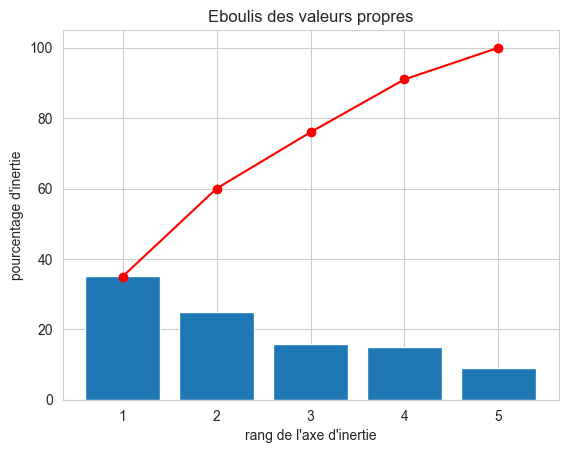

In [75]:
# Traçons le diagramme d'éboulis
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()   #Somme cumulée des pourcentage d'explication de variance

x_list = range(1, 6)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Avec les 4 premières composantes,  plus de 90% de la variance des données peut être expliquée. Nous garderons donc ces 4 premières composantes.

Regardonc les plus en détails :

In [76]:
pcs = pd.DataFrame(pca.components_)
pcs=pcs.iloc[:4]
variables_name=['montant_total','frais_livraison','satisfaction','retard_livraison','nb_versement']
pcs.columns = variables_name
pcs.index = ['F1','F2','F3','F4']
pcs.round(2)


montant_total  frais_livraison  satisfaction  retard_livraison  \
F1           0.64             0.58         -0.04             -0.08   
F2           0.05            -0.04         -0.71              0.70   
F3           0.12             0.57          0.07              0.13   
F4           0.01            -0.02          0.70              0.70   

    nb_versement  
F1          0.50  
F2          0.03  
F3         -0.80  
F4          0.16

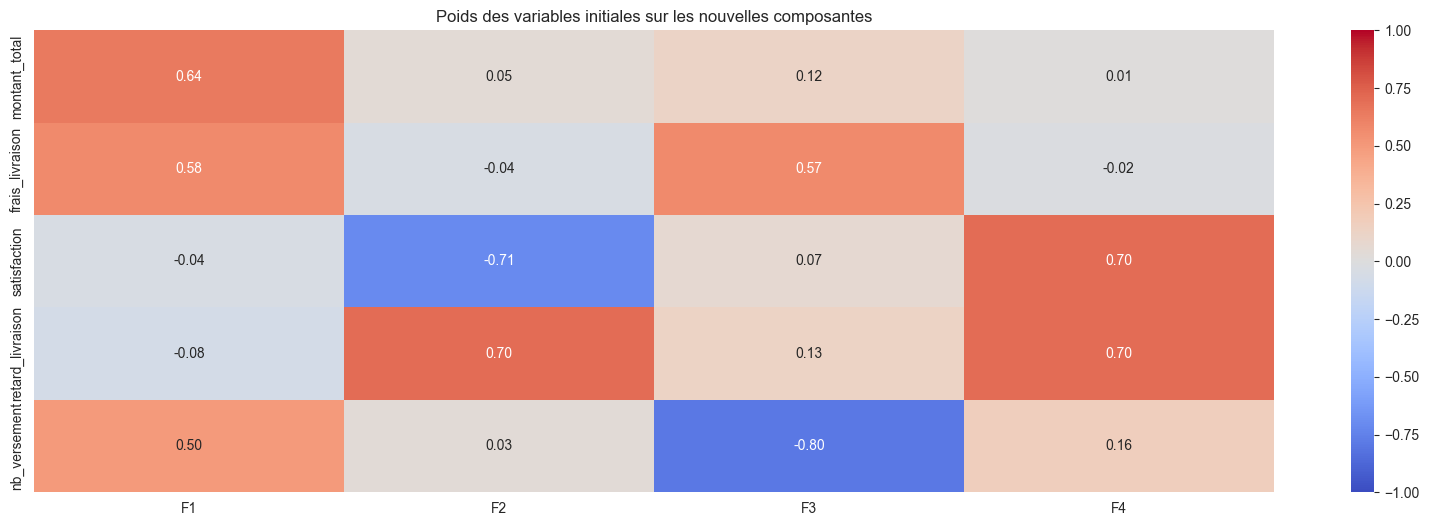

In [77]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title("Poids des variables initiales sur les nouvelles composantes")
plt.show()

Traçons les cercles de corrélations :

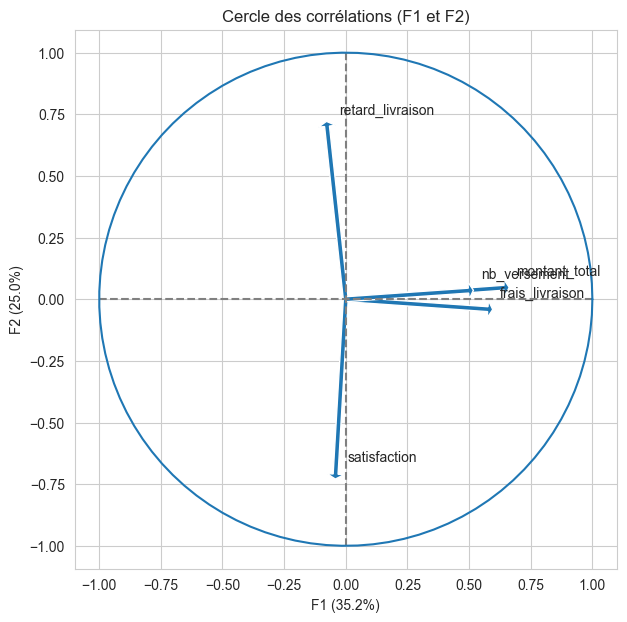

In [78]:
x, y = 0,1    #0 for PC1 / 1 for PC2
fig, ax = plt.subplots(figsize=(7, 7))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.02,
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             variables_name[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

Pour l'axe F1, on voit que les variables "montant_total", "frais_livraison" et "nb_versement" sont positivement corrélées à F1. Donc plutôt, une variable qui correspond au panier moyen du client.

Pour l'axe F2, on voit que la variable "retard_livraison" est la plus positivement corrélée à F2 et que la variable "satisfaction" est la plus négativement corrélée à F2. Donc plutôt, une variable qui correspond au retard de livraison par rapport à ce qui avait été annoncé et à l'insatisfaction du client. C'est assez logique qu'un retard important entraine plutôt une insatisfaction.

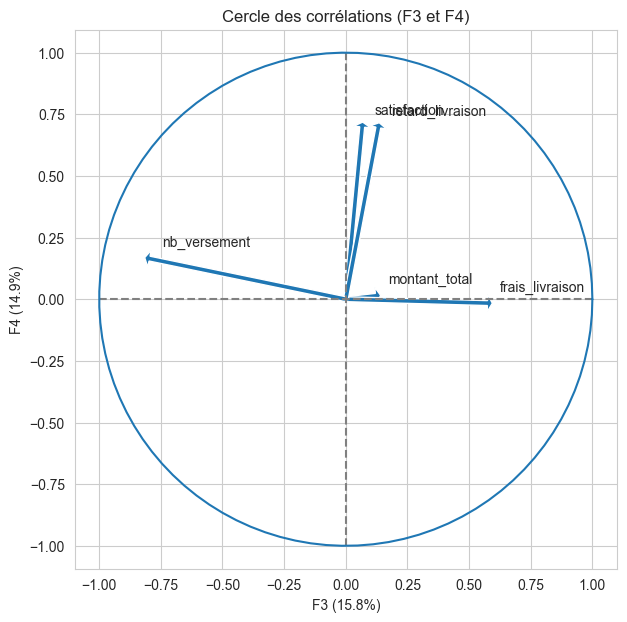

In [79]:
x, y = 2,3   #2 for PC3 / 3 for PC4
fig, ax = plt.subplots(figsize=(7, 7))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[2, i],  #2 for PC3
             pca.components_[3, i],  #3 for PC4
             head_width=0.07,
             head_length=0.02,
             width=0.02,              )

    plt.text(pca.components_[2, i] + 0.05,
             pca.components_[3, i] + 0.05,
             variables_name[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

Pour l'axe F3, on voit que la variable  "frais_livraison" est positivement corrélée à F3, tandis que "nb_versement" est négativement corrélées à F3. Donc plutôt, une variable qui correspond à la fréquence d'achat et inversement au nombre de versement du client.

Pour l'axe F4, on voit que la variable "satisfaction" et "retard_livraison" sont positivement corrélées à F4. Donc plutôt, une variable qui correspond au retard de livraison par rapport à ce qui avait été annoncé et à la satisfaction du client (malgré le retard).

In [80]:
data_cluster2_pca=data_cluster2_pca[:,:4]

In [81]:
data_cluster2_pca

array([[ 5.17889116e-01,  9.13829610e-02, -1.67616950e+00,
         1.26489371e+00],
       [-1.77077896e+00,  4.90100758e-01,  1.07787414e-03,
         2.97079106e-01],
       [ 5.38652427e-01,  1.31991151e+00, -1.51265902e+00,
         4.16753176e-01],
       ...,
       [-2.33384278e-01, -1.80306020e+00,  5.99601193e-01,
        -9.30527820e-01],
       [ 4.70836086e-01, -5.97654933e-01, -7.68590826e-01,
         4.86152858e-01],
       [-2.43990536e-01, -7.61040752e-01, -7.95738357e-01,
         2.88601048e-01]])

In [82]:
# Créer une instance de Scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()
data_cluster2_pca=pd.DataFrame(data_cluster2_pca)
# Normalisation des données
data_cluster2_pca_norm = pd.DataFrame(scaler.fit_transform(data_cluster2_pca),columns=data_cluster2_pca.columns)

data_cluster2_pca_norm.describe(include="all")

0             1             2             3
count  96096.000000  96096.000000  96096.000000  96096.000000
mean       0.203601      0.396165      0.396667      0.392894
std        0.078104      0.044642      0.069506      0.038022
min        0.000000      0.000000      0.000000      0.000000
25%        0.149912      0.369476      0.356603      0.374815
50%        0.186607      0.386999      0.406129      0.398873
75%        0.239150      0.412003      0.436456      0.416919
max        1.000000      1.000000      1.000000      1.000000

#### Recherche du nombre de clusters avec la méthode du coude

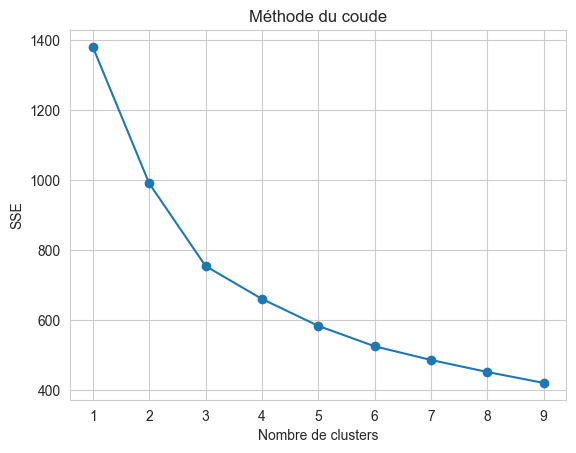

In [83]:
SSE=[]
for i in range(1,10):
    kmeans_sse=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sse.fit(data_cluster2_pca_norm)
    SSE.append(kmeans_sse.inertia_)

# Visualisation de la courbe de la méthode du coude
plt.plot(range(1,10),SSE,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.title('Méthode du coude')
plt.show()

#### Recherche du nombre de clusters avec la méthode de la silhouette

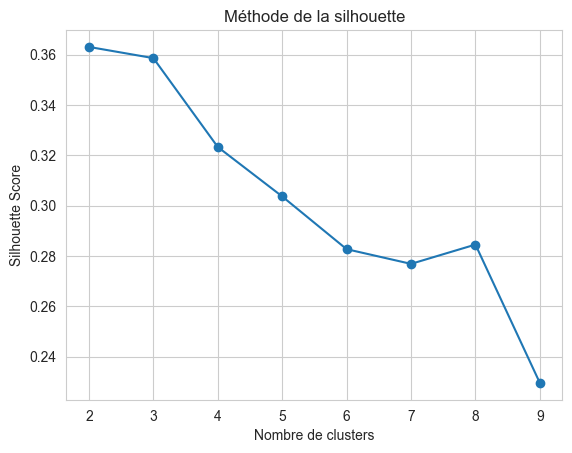

In [84]:
sil=[]
for i in range(2,10):
    kmeans_sil=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    kmeans_sil.fit(data_cluster2_pca_norm)
    labels = kmeans_sil.labels_
    sil.append(silhouette_score(data_cluster2_pca_norm,labels))

plt.plot(range(2,10),sil,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la silhouette')
plt.show()

#### Optimisation du nombre de clusters avec la méthode de Davies-Bouldin

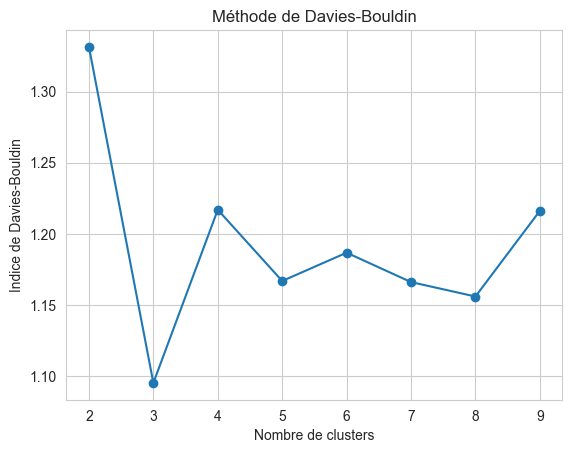

In [85]:
db=[]
for i in range(2,10):
    kmeans_db=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=42)
    clusters=kmeans_db.fit_predict(data_cluster2_pca_norm)
    db.append(davies_bouldin_score(data_cluster2_pca_norm,clusters))

plt.plot(range(2,10),db,marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Indice de Davies-Bouldin')
plt.title('Méthode de Davies-Bouldin')
plt.show()

Pour n_clusters = 3 Le score de silhouette moyen est de: 0.3586316385053711
Pour n_clusters = 4 Le score de silhouette moyen est de: 0.323305975684677
Pour n_clusters = 5 Le score de silhouette moyen est de: 0.3036499950810925


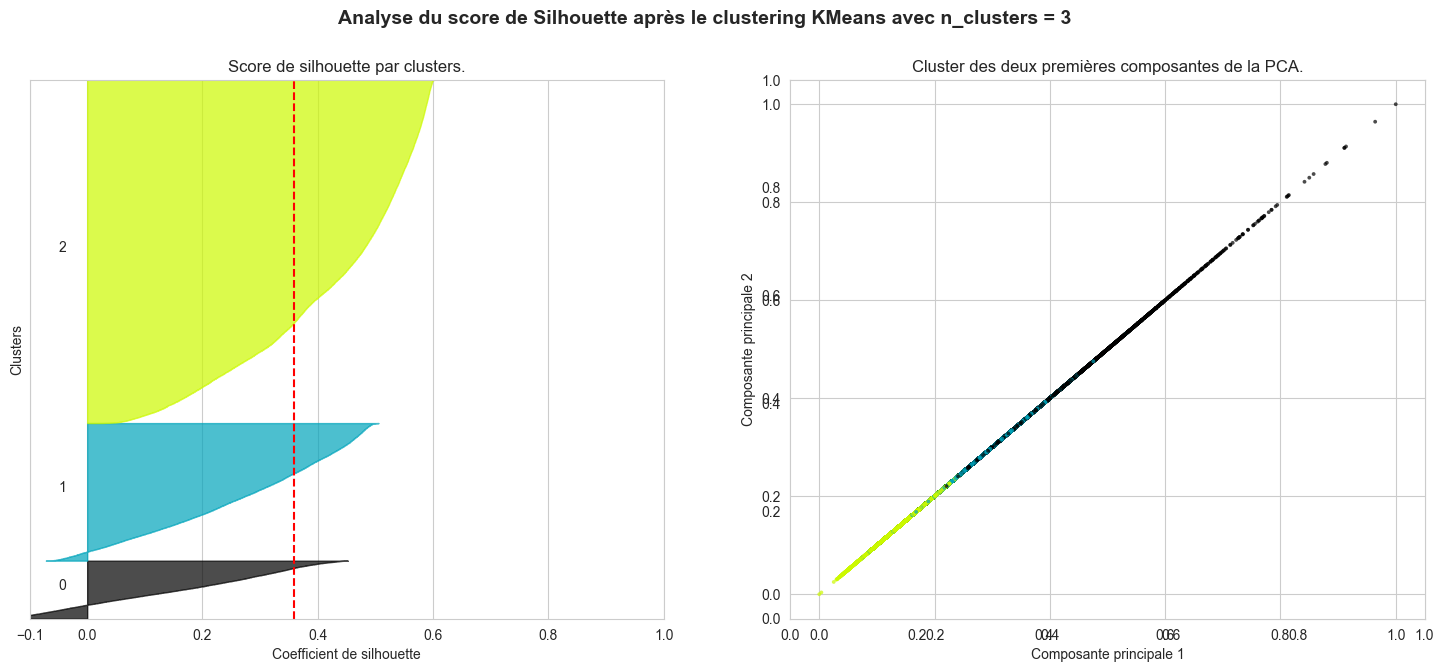

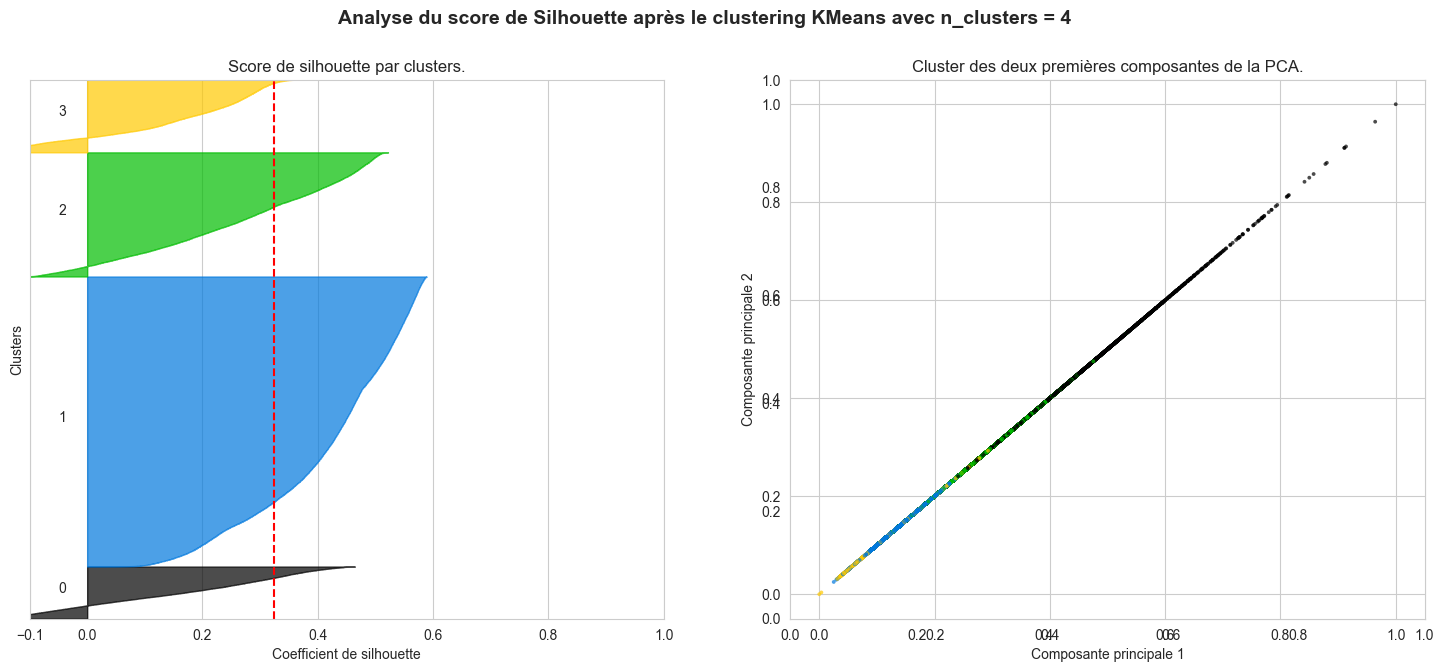

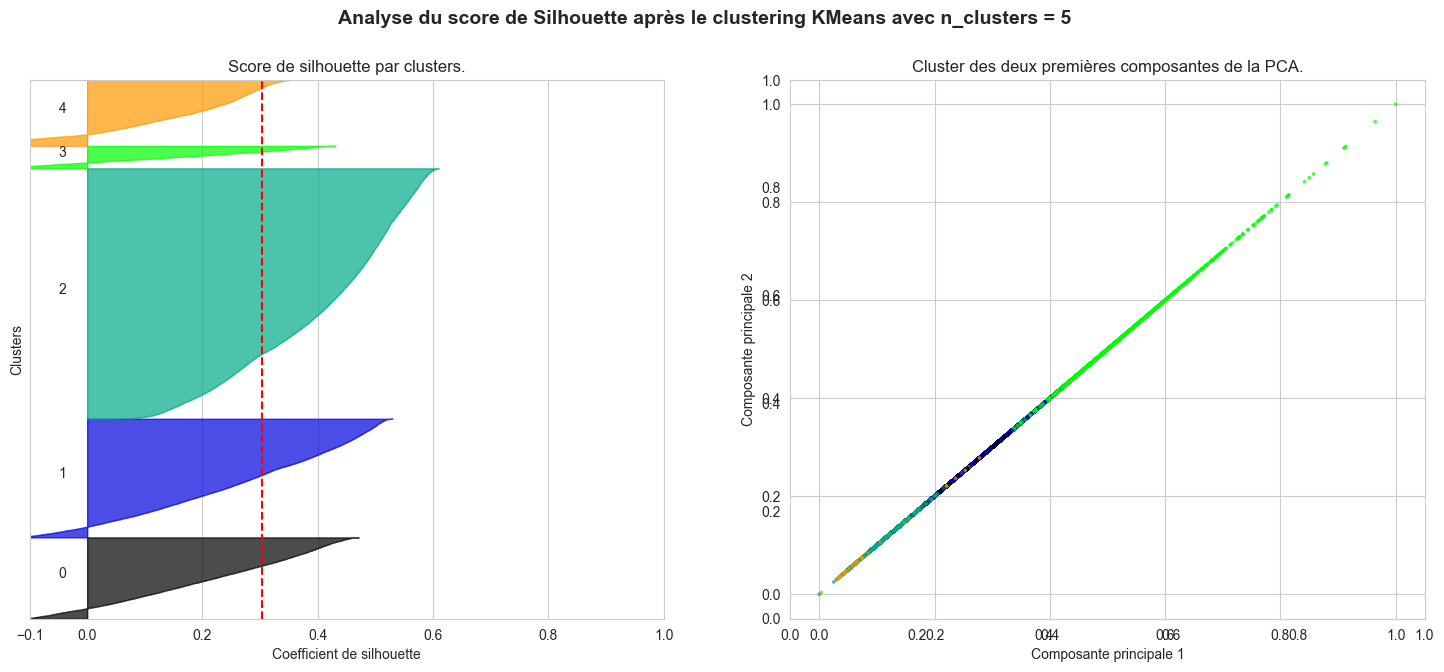

In [86]:
range_n_clusters = [3,4,5]

for n_clusters in range_n_clusters:
    # Creation des graphiques 1 lignes, 3 colonnes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Premier graphique : score de silhouette par cluster
    # Le coefficient de silhouette peut aller de -1, 1 mais on le fera de [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    #  (n_clusters+1)*10 pour insérer un espace pour démarquer les clusters
    ax1.set_ylim([0, len(data_cluster2_pca_norm) + (n_clusters + 1) * 10])

    # Clustering
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=300,random_state=42)
    cluster_labels = clusterer.fit_predict(data_cluster2_pca_norm)

    # Calcul des scores de silhouette
    silhouette_avg = silhouette_score(data_cluster2_pca_norm, cluster_labels)
    print(
        "Pour n_clusters =",
        n_clusters,
        "Le score de silhouette moyen est de:",
        silhouette_avg,
    )

    # Calcul du score de silhouette pour chaque échantillon
    sample_silhouette_values = silhouette_samples(data_cluster2_pca_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Titre du graphiques et étiquettes
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Score de silhouette par clusters.")
    ax1.set_xlabel("Coefficient de silhouette")
    ax1.set_ylabel("Clusters")

    # Ligne verticale pour le score de silhouette moyen
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Deuxième graphique : clusters formés selon les deux premières variables "fréquence" et "recence"

    # # PCA
    # pca = PCA(n_components=2)
    # data_pca = pca.fit_transform(data_cluster2_pca)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(data_cluster2_pca_norm.iloc[:, 0],data_cluster2_pca_norm.iloc[:, 0], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax2.set_title("Cluster des deux premières composantes de la PCA.")
    ax2.set_xlabel("Composante principale 1")
    ax2.set_ylabel("Composante principale 2")

    plt.suptitle(
        "Analyse du score de Silhouette après le clustering KMeans avec n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Après la PCA, on remarque que la réduction de dimensions n'est pas optimale puisque 4 composantes sont nécessaires.

De plus, les scores de silhouettes diminuent et la séparation des clusters semblerait être plus optimale avec 3 clusters, car avec plus de clusters certains n'atteignent pas le score de silhouette moyen, cependant, un cluster dominerait largement les autres en terme de taille.

Par conséquent, continuons sans PCA puisqu'elle ne semble pas forcément pertinente dans ce cas.

### K-Means à 4 clusters ( sans PCA préalable)

In [87]:
data_cluster2_k4=pd.DataFrame(data_cluster2_scale_norm)

kmeans_4 = KMeans(init='k-means++',n_clusters=4,n_init=10,max_iter=300,random_state=42)

kmeans_4.fit(data_cluster2_k4)

# Ajout des labels de cluster au dataframe
data_cluster2_k4['cluster'] = kmeans_4.labels_

In [88]:
data_cluster2_k4

montant_total  frais_livraison  satisfaction  retard_livraison  \
0           0.101906         0.171147          1.00          0.423881   
1           0.044608         0.142251          0.75          0.423881   
2           0.079435         0.205019          0.50          0.432836   
3           0.056501         0.207445          0.75          0.402985   
4           0.120039         0.203045          1.00          0.414925   
...              ...              ...           ...               ...   
96091       0.388977         0.764018          1.00          0.358209   
96092       0.078676         0.219230          0.75          0.429851   
96093       0.090721         0.234664          1.00          0.349254   
96094       0.098914         0.213591          1.00          0.397015   
96095       0.072368         0.188585          1.00          0.391045   

       nb_versement  cluster  
0          0.577350        2  
1          0.204124        3  
2          0.577350        3  
3          0.408248        3  
4          0.500000        2  
...             ...      ...  
96091      0.645497        2  
96092      0.204124        3  
96093      0.204124        0  
96094      0.456435        2  
96095      0.408248        2  

[96096 rows x 6 columns]

In [89]:
# Créer une instance de SimpleImputer
imputer = SimpleImputer(strategy='median')
# Remodeler la colonne en un tableau 2D
data_temp = data_cluster2_k4['nb_versement'].values.reshape(-1, 1)
data_temp_ = data_cluster2_k4['satisfaction'].values.reshape(-1, 1)
data_temp__ = data_cluster2_k4['retard_livraison'].values.reshape(-1, 1)

data_cluster2_k4['nb_versement'] = imputer.fit_transform(data_temp)
data_cluster2_k4['satisfaction'] = imputer.fit_transform(data_temp_)
data_cluster2_k4['retard_livraison'] = imputer.fit_transform(data_temp__)

data_cluster2_k4_vm=show_miss_val(data_cluster2_k4)
data_cluster2_k4_vm.head(26)

Notre dataframe a 6 variables.
 Il y a 0 variables contenant des valeurs manquantes.


Empty DataFrame
Columns: [variable, miss_val]
Index: []

In [90]:
data_cluster2_scale

montant_total  frais_livraison  satisfaction  retard_livraison  \
0          11.912179         3.464102           5.0              -5.0   
1           5.214403         2.879236           4.0              -5.0   
2           9.285473         4.149699           3.0              -2.0   
3           6.604544         4.198809           4.0             -12.0   
4          14.031750         4.109745           5.0              -8.0   
...              ...              ...           ...               ...   
96091      45.468890        15.464152           5.0             -27.0   
96092       9.196739         4.437342           4.0              -3.0   
96093      10.604716         4.749737           5.0             -30.0   
96094      11.562439         4.323193           5.0             -14.0   
96095       8.459314         3.817067           5.0             -16.0   

       nb_versement  
0          2.828427  
1          1.000000  
2          2.828427  
3          2.000000  
4          2.449490  
...             ...  
96091      3.162278  
96092      1.000000  
96093      1.000000  
96094      2.236068  
96095      2.000000  

[96096 rows x 5 columns]

In [91]:
# Ajout de la colonne 'cluster' sur le jeu de données du cluster 2 initial :
data_cluster2_k4_final = data_cluster2.merge(data_cluster2_k4['cluster'],left_index=True, right_index=True, how='left')

data_cluster2_k4_final

frais_livraison  montant_total  satisfaction  retard_livraison  \
0                12.00         141.90           5.0              -5.0   
1                 8.29          27.19           4.0              -5.0   
2                17.22          86.22           3.0              -2.0   
3                17.63          43.62           4.0             -12.0   
4                16.89         196.89           5.0              -8.0   
...                ...            ...           ...               ...   
96091           239.14        2067.42           5.0             -27.0   
96092            19.69          84.58           4.0              -3.0   
96093            22.56         112.46           5.0             -30.0   
96094            18.69         133.69           5.0             -14.0   
96095            14.57          71.56           5.0             -16.0   

       nb_versement  cluster  
0               8.0        2  
1               1.0        3  
2               8.0        3  
3               4.0        3  
4               6.0        2  
...             ...      ...  
96091          10.0        2  
96092           1.0        3  
96093           1.0        0  
96094           5.0        2  
96095           4.0        2  

[96096 rows x 6 columns]

In [92]:
# Ajout du jeu de données du cluster 2 au jeu de données issu du feature engineering et supression des variables doublons:
data_fe_cluster2_k4 = data_fe_client.merge(data_cluster2_k4_final,left_index=True, right_index=True, how='left')
cols_to_drop = ["order_id", "payment_total","freight_value","review_score_moy","late_delivery","payment_payment_installments"]
data_fe_cluster2_k4 = data_fe_cluster2_k4.drop(cols_to_drop, axis=1)
data_fe_cluster2_k4

customer_unique_id  estimated_delivery_delay  \
0      0000366f3b9a7992bf8c76cfdf3221e2                      11.0   
1      0000b849f77a49e4a4ce2b2a4ca5be3f                       8.0   
2      0000f46a3911fa3c0805444483337064                      28.0   
3      0000f6ccb0745a6a4b88665a16c9f078                      32.0   
4      0004aac84e0df4da2b147fca70cf8255                      21.0   
...                                 ...                       ...   
96091  fffcf5a5ff07b0908bd4e2dbc735a684                      55.0   
96092  fffea47cd6d3cc0a88bd621562a9d061                      33.0   
96093  ffff371b4d645b6ecea244b27531430a                      45.0   
96094  ffff5962728ec6157033ef9805bacc48                      26.0   
96095  ffffd2657e2aad2907e67c3e9daecbeb                      24.0   

       true_delivery_delay   price  frais_livraison  montant_total  \
0                      6.0  129.90            12.00         141.90   
1                      3.0   18.90             8.29          27.19   
2                     26.0   69.00            17.22          86.22   
3                     20.0   25.99            17.63          43.62   
4                     13.0  180.00            16.89         196.89   
...                    ...     ...              ...            ...   
96091                 28.0  680.00           239.14        2067.42   
96092                 30.0   64.89            19.69          84.58   
96093                 15.0   89.90            22.56         112.46   
96094                 12.0  115.00            18.69         133.69   
96095                  8.0   56.99            14.57          71.56   

       satisfaction  retard_livraison  nb_versement  cluster  
0               5.0              -5.0           8.0        2  
1               4.0              -5.0           1.0        3  
2               3.0              -2.0           8.0        3  
3               4.0             -12.0           4.0        3  
4               5.0              -8.0           6.0        2  
...             ...               ...           ...      ...  
96091           5.0             -27.0          10.0        2  
96092           4.0              -3.0           1.0        3  
96093           5.0             -30.0           1.0        0  
96094           5.0             -14.0           5.0        2  
96095           5.0             -16.0           4.0        2  

[96096 rows x 10 columns]

In [93]:
# Recherche de valeurs manquantes
data_fe_cluster2_k4_vm=show_miss_val(data_fe_cluster2_k4)
data_fe_cluster2_k4_vm.head(26)

Notre dataframe a 10 variables.
 Il y a 4 variables contenant des valeurs manquantes.


variable  miss_val
8         nb_versement  0.000010
6         satisfaction  0.007451
2  true_delivery_delay  0.028513
7     retard_livraison  0.028513

In [94]:
# Créer une instance de SimpleImputer
imputer = SimpleImputer(strategy='median')
# Remodeler la colonne en un tableau 2D
data_temp = data_fe_cluster2_k4['nb_versement'].values.reshape(-1, 1)
data_temp_ = data_fe_cluster2_k4['satisfaction'].values.reshape(-1, 1)
data_temp__ = data_fe_cluster2_k4['retard_livraison'].values.reshape(-1, 1)
data_temp___ = data_fe_cluster2_k4['true_delivery_delay'].values.reshape(-1, 1)

data_fe_cluster2_k4['nb_versement'] = imputer.fit_transform(data_temp)
data_fe_cluster2_k4['satisfaction'] = imputer.fit_transform(data_temp_)
data_fe_cluster2_k4['retard_livraison'] = imputer.fit_transform(data_temp__)
data_fe_cluster2_k4['true_delivery_delay'] = imputer.fit_transform(data_temp___)

data_fe_cluster2_k4_vm=show_miss_val(data_fe_cluster2_k4)
data_fe_cluster2_k4_vm.head(26)

Notre dataframe a 10 variables.
 Il y a 0 variables contenant des valeurs manquantes.


Empty DataFrame
Columns: [variable, miss_val]
Index: []

In [95]:
df_cluster2_k4_0 = data_fe_cluster2_k4[data_fe_cluster2_k4['cluster'] == 0]
df_cluster2_k4_1 = data_fe_cluster2_k4[data_fe_cluster2_k4['cluster'] == 1]
df_cluster2_k4_2 = data_fe_cluster2_k4[data_fe_cluster2_k4['cluster'] == 2]
df_cluster2_k4_3 = data_fe_cluster2_k4[data_fe_cluster2_k4['cluster'] == 3]

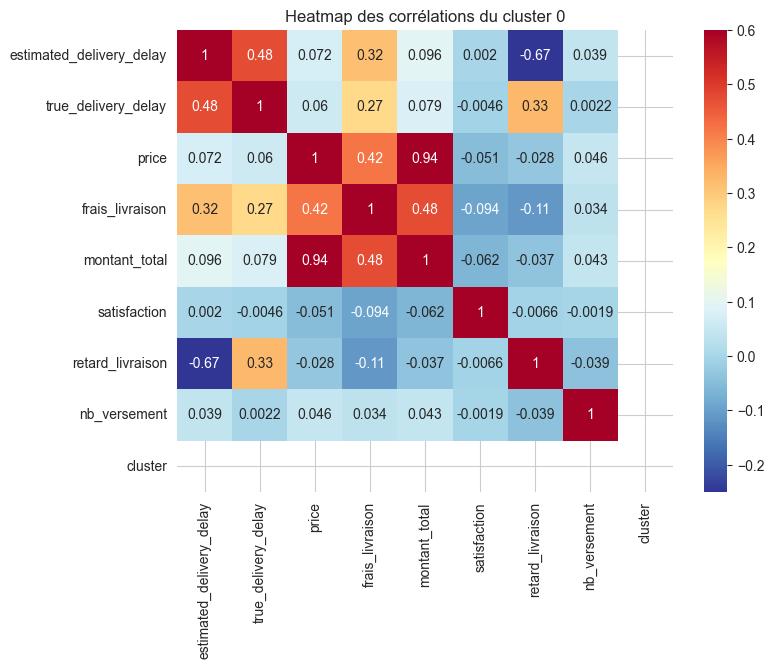

In [96]:
plt.figure(figsize = (8, 6))
data_corr = df_cluster2_k4_0.select_dtypes(include=['float', 'int32'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 0');

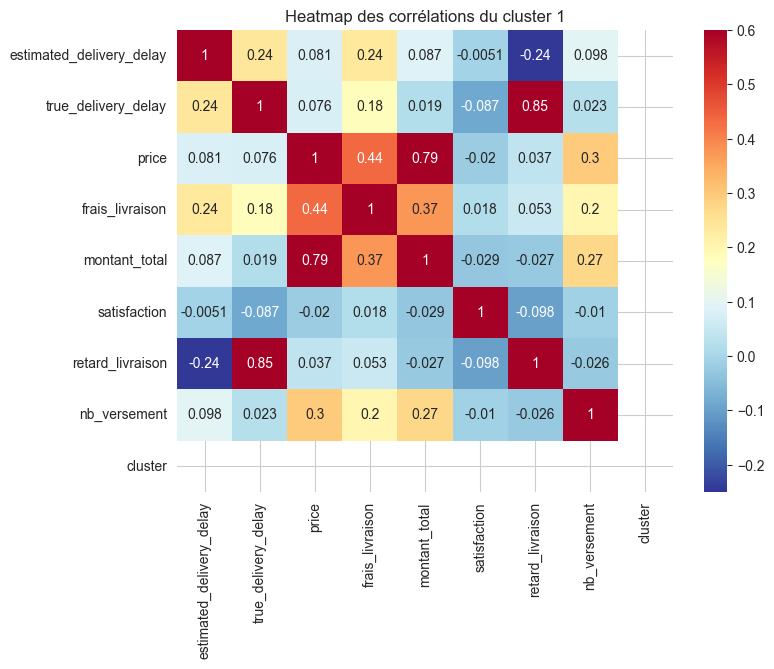

In [97]:
plt.figure(figsize = (8, 6))
data_corr = df_cluster2_k4_1.select_dtypes(include=['float', 'int32'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 1');

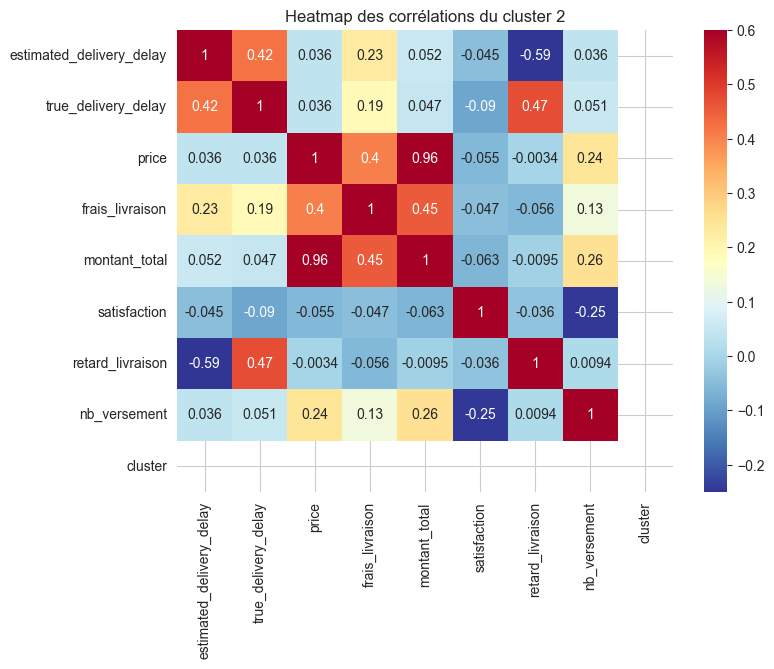

In [98]:
plt.figure(figsize = (8, 6))
data_corr = df_cluster2_k4_2.select_dtypes(include=['float', 'int32'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 2');

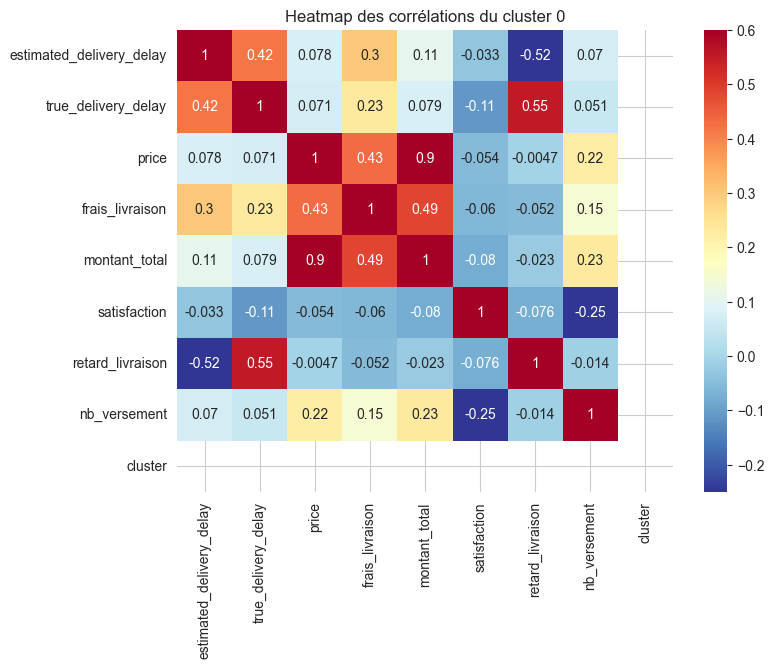

In [99]:
plt.figure(figsize = (8, 6))
data_corr = df_cluster2_k4_3.select_dtypes(include=['float', 'int32'])
# Heatmap des correlations
sns.heatmap(data_corr.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations du cluster 0');

Les corrélations sont proches entre les 4 clusters.

On visualise que dans le cluster 0, il y a une corrélations négative plus importante entre la satisfaction et la fréquence que dans les autres clusters.

On visualise que dans le cluster 1, il y a moins de corrélations entre la délai de livraison estimé et réel que dans les autres clusters. De même, la corrélation négative entre le délai de livraison estimé et le retard/avance de livraison est moins importante.


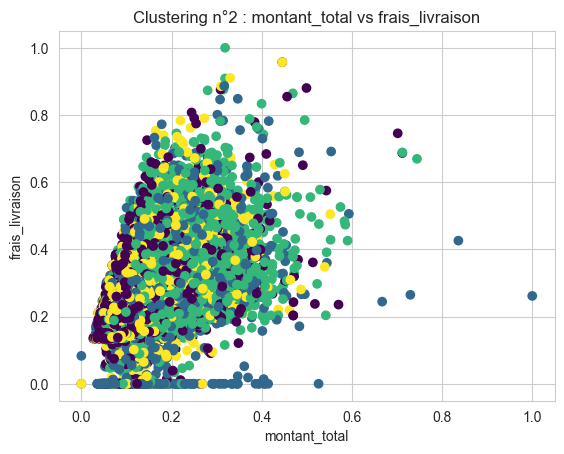

In [100]:
# Visualisation des résultats en 2D
plt.scatter(data_cluster2_k4['montant_total'],data_cluster2_k4['frais_livraison'],c=data_cluster2_k4['cluster'],cmap='viridis')
plt.xlabel('montant_total')
plt.ylabel('frais_livraison')
plt.title('Clustering n°2 : montant_total vs frais_livraison')
plt.show()

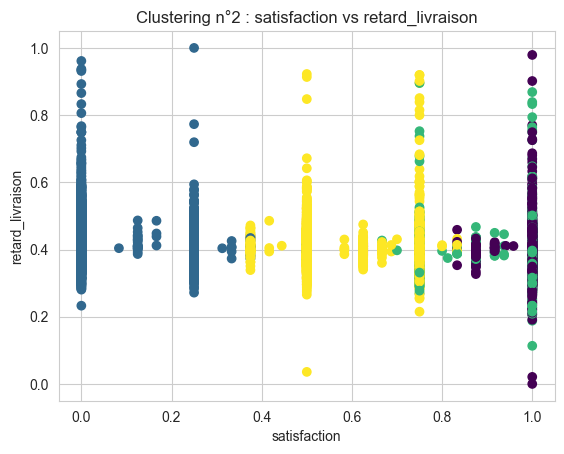

In [103]:
# Visualisation des résultats en 2D
plt.scatter(data_cluster2_k4['satisfaction'],data_cluster2_k4['retard_livraison'],c=data_cluster2_k4['cluster'],cmap='viridis')
plt.xlabel('satisfaction')
plt.ylabel('retard_livraison')
plt.title('Clustering n°2 : satisfaction vs retard_livraison')
plt.show()

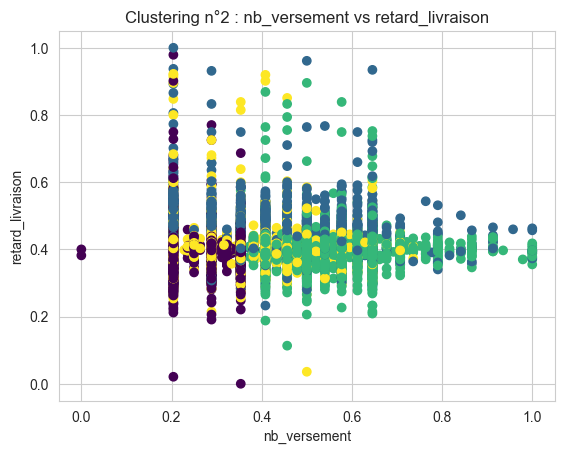

In [104]:
# Visualisation des résultats en 2D
plt.scatter(data_cluster2_k4['nb_versement'],data_cluster2_k4['retard_livraison'],c=data_cluster2_k4['cluster'],cmap='viridis')
plt.xlabel('nb_versement')
plt.ylabel('retard_livraison')
plt.title('Clustering n°2 : nb_versement vs retard_livraison')
plt.show()

In [105]:
data_fe_cluster2_k4=data_fe_cluster2_k4.drop(['customer_unique_id'], axis=1)
features = data_fe_cluster2_k4.columns[:-1]
data_fe_cluster2_k4_means = data_fe_cluster2_k4.groupby('cluster')[features].mean()
data_fe_cluster2_k4_means

estimated_delivery_delay  true_delivery_delay       price  \
cluster                                                              
0                       23.501928            10.449762   98.184776   
1                       25.313716            18.679151  133.350711   
2                       25.422159            11.636328  220.496875   
3                       24.540338            12.749947  108.956648   

         frais_livraison  montant_total  satisfaction  retard_livraison  \
cluster                                                                   
0              18.494498     125.485107      4.997332        -13.035052   
1              21.161253     195.537296      1.222512         -6.116076   
2              25.884202     265.212917      4.847679        -13.756379   
3              20.232036     143.035295      3.659907        -11.749043   

         nb_versement  
cluster                
0            1.454326  
1            3.135435  
2            6.769486  
3            2.231029

In [106]:
data_fe_cluster2_k4_scal=data_fe_cluster2_k4.copy()
features = data_fe_cluster2_k4.columns[:-1]
scaler = MinMaxScaler()
data_fe_cluster2_k4_scal[features] = scaler.fit_transform(data_fe_cluster2_k4[features])
data_fe_cluster2_k4_scal_means = data_fe_cluster2_k4_scal.groupby('cluster')[features].mean()
data_fe_cluster2_k4_scal_means

estimated_delivery_delay  true_delivery_delay     price  \
cluster                                                            
0                        0.139623             0.049761  0.013290   
1                        0.151388             0.088948  0.018050   
2                        0.152092             0.055411  0.029845   
3                        0.146366             0.060714  0.014748   

         frais_livraison  montant_total  satisfaction  retard_livraison  \
cluster                                                                   
0               0.045144       0.009184      0.999333          0.399895   
1               0.051653       0.014310      0.055628          0.420549   
2               0.063182       0.019409      0.961920          0.397742   
3               0.049385       0.010468      0.664977          0.403734   

         nb_versement  
cluster                
0            0.060597  
1            0.130643  
2            0.282062  
3            0.092960

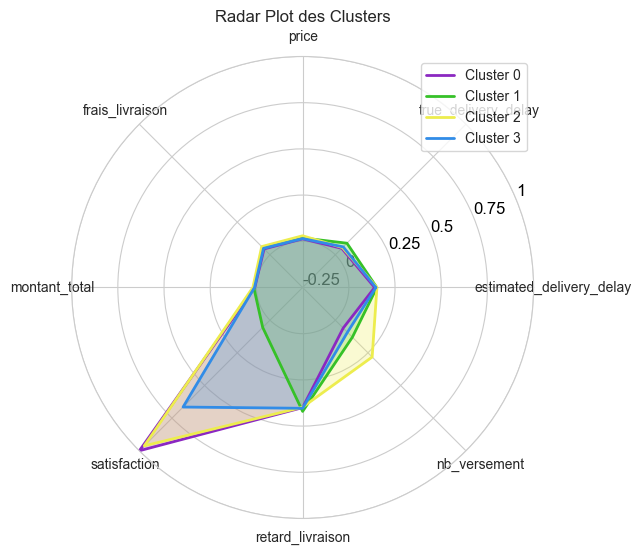

In [107]:
features = data_fe_cluster2_k4_scal.columns[:-1]

# Normalisation des colonnes de ces données
# scaler = MinMaxScaler()
# data_fe_cluster2[features] = scaler.fit_transform(data_fe_cluster2[features])

# Calcul des moyennes des nouvelles variables pour chaque cluster
# cluster_means = data_fe_cluster2.groupby('cluster')[features].mean()

# Calcul des angles pour le graphique en toile d'araignée
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

# Création de la figure et du sous-graphique
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})
cluster_colors = ['#8b28c1','#36c128','#EDED4E','#318ce7']

# Tracer chaque cluster
for i in range(4):
    values = data_fe_cluster2_k4_scal_means.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}", color=cluster_colors[i])

# Remplissage des zones à l'intérieur du polygone pour chaque cluster
ax.fill(angles, data_fe_cluster2_k4_scal_means.iloc[0].tolist() + [data_fe_cluster2_k4_scal_means.iloc[0, 0]], alpha=0.25, color=cluster_colors[0])
ax.fill(angles, data_fe_cluster2_k4_scal_means.iloc[1].tolist() + [data_fe_cluster2_k4_scal_means.iloc[1, 0]], alpha=0.25, color=cluster_colors[1])
ax.fill(angles, data_fe_cluster2_k4_scal_means.iloc[2].tolist() + [data_fe_cluster2_k4_scal_means.iloc[2, 0]], alpha=0.25, color=cluster_colors[2])
ax.fill(angles, data_fe_cluster2_k4_scal_means.iloc[3].tolist() + [data_fe_cluster2_k4_scal_means.iloc[3, 0]], alpha=0.25, color=cluster_colors[3])

# Étiquettes des axes et légendes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
ax.set_title("Radar Plot des Clusters")
ax.set_yticks([-0.25, 0, 0.25,0.5,0.75, 1],
                   ["-0.25", "0", "0.25","0.5","0.75", "1"],
                   color="black",
                   size=12)
ax.set_ylim(-0.25, 1)
ax.legend()

plt.show()

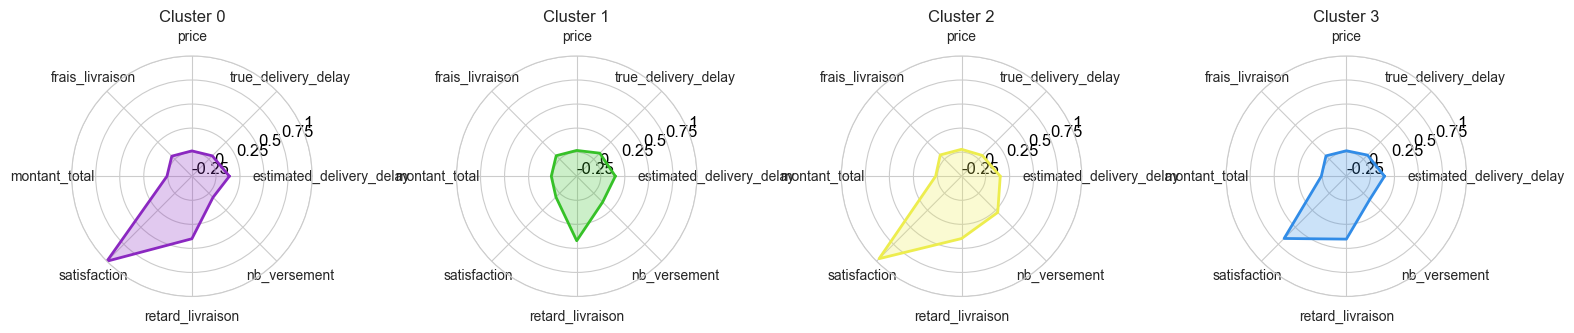

In [108]:
# Liste de toutes les variables que vous souhaitez inclure dans le radar plot
features = data_fe_cluster2_k4_scal.columns[:-1]

# # Normalisation des colonnes de ces données
# scaler = MinMaxScaler()
# data_fe_cluster2[features] = scaler.fit_transform(data_fe_cluster2[features])

# # Calcul des moyennes des nouvelles variables pour chaque cluster
# # Assurez-vous que les nouvelles variables sont présentes dans data_rfm_norm
# cluster_means = data_fe_cluster2.groupby('cluster')[features].mean()

# Calcul des angles pour le graphique en toile d'araignée
angles = [n / float(len(features)) * 2 * np.pi for n in range(len(features))]
angles += angles[:1]

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1,4,figsize=(18, 8), subplot_kw={'polar': True})
cluster_colors = ['#8b28c1','#36c128','#EDED4E','#318ce7']
plt.subplots_adjust(wspace=0.6)

# Tracer chaque cluster
for i in range(4):
  ax=axes[i]
  values = data_fe_cluster2_k4_scal_means.iloc[i].tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}", color=cluster_colors[i])
  ax.fill(angles, values, alpha=0.25, facecolor=cluster_colors[i])

# étiquettes des axes et légende
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(features)
  ax.set_title(f"Cluster {i}")
  ax.set_yticks([-0.25, 0, 0.25,0.5,0.75, 1],
                   ["-0.25", "0", "0.25","0.5","0.75", "1"],
                   color="black",
                   size=12)
  ax.set_ylim(-0.25, 1)

plt.show()

Ce deuxième clustering avec l'algorithme du kmeans définit 3 clusters avec peu de différences :
- les clients très satisfaits avec quasiment pas d'échelonnement de leur paiment (violet), un panier moyen peu élevé et des avances de livraisons. Cela correspond plutôt à des clients "très satisfaits avec panier moyen faible sans échelonnement de paiement" pour l'entreprise, c'est à dire des clients conquis qui vont surement réitérer des commandes sur le site et qui rapportent peu à l'entreprise.
- les clients peu satisfaits (vert) avec des délais de livraisons plus longs que les autres. Cela correspond plutôt à des clients "mécontents" pour l'entreprise, c'est à dire des clients perdus qui ne commanderont plus sur le site à moins d'un éventuel geste commercial.
- les clients satisfaits avec peu d'échelonnement de leur paiment (jaune) et un panier moyen peu élevé. Cela correspond plutôt à des clients "satisfaits avec panier moyen faible et peu d'échelonnement de paiement" pour l'entreprise, c'est à dire des clients contents qui pourront réitérer des commandes sur le site et rapporter peu à l'entreprise si la concurrence ne fait pas mieux, ou aller ailleurs dans le cas contraires.
-  les clients très satisfaits avec beaucoup d'échelonnement de leur paiment (bleu), un panier moyen élevé et des avances de livraisons. Cela correspond plutôt à des clients "très satisfaits avec panier moyen élevé et nombreux échelonnements de paiement" pour l'entreprise, c'est à dire des clients conquis qui vont surement réitérer des commandes sur le site et qui rapportent beaucoup à l'entreprise.

In [110]:
# Calcul de la répartition des clusters
data_cluster =data_fe_cluster2_k4_scal.groupby('cluster', dropna=False)['retard_livraison'].count()
print(data_cluster)

cluster
0    40070
1    13891
2    18315
3    23820
Name: retard_livraison, dtype: int64


Text(0.5, 1.0, 'Proportion des clusters dans la population')

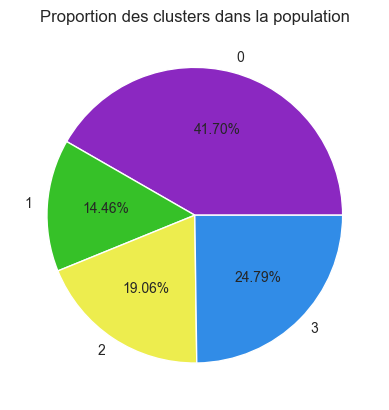

In [111]:
labels = ['0','1','2','3']
colors = ['#8b28c1','#36c128','#EDED4E','#318ce7']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des clusters dans notre base de données
plt.pie(x=data_cluster, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des clusters dans la population")

Les clients peu satisfaits correspondent à environ 14% de la population (vert) contrairement aux client très satisfaits qui correspondent à 61% (violet + jaune).

Les clients avec un panier moyen élevé (jaune) correspondent à 19% de la population.

In [112]:
# Calcul de la somme des montants en fonction des clusters
data_cluster_ca =data_fe_cluster2_k4_scal.groupby('cluster', dropna=False)['montant_total'].sum()
print(data_cluster_ca)

cluster
0    367.985860
1    198.784593
2    355.484934
3    249.347247
Name: montant_total, dtype: float64


Text(0.5, 1.0, 'Proportion des clusters en fonction du CA')

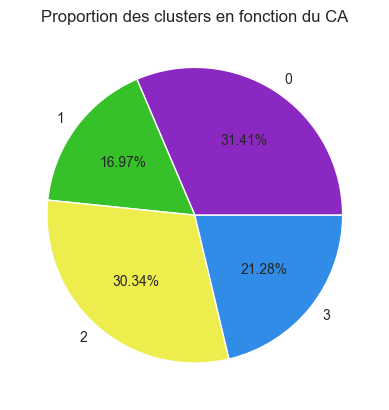

In [113]:
labels = ['0','1','2','3']
colors = ['#8b28c1','#36c128','#EDED4E','#318ce7']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des clusters dans notre base de données
plt.pie(x=data_cluster_ca, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des clusters en fonction du CA")

Les clients avec un panier moyen élevé (jaune) représente tout de même 30% du CA même s'il ne représenteque 19% de la population.

C'est un pourcentage quasiment identique aux clients très satisfaits avec un panier moyen peu élevé (violet) avec 31% du CA.

Les clients très satisfaits rapportent donc 62% du CA total et correspondent à 61% de la population comme vu au dessus.

#### Evaluation

In [114]:
data_cluster2_k4=data_cluster2_k4.drop(['cluster'],axis=1)

In [115]:
# on veut des distances intraclusters (c'est l'homogénéité) faibles et des distances interclusters (la séparation) grandes.
# cela correspond à un silhouette score égal à 1, un score de Davies Bouldin bas et un score Calinsky Harabasz élevé.
sil_score2=silhouette_score(data_cluster2_k4,kmeans_4.labels_)
db_score2=davies_bouldin_score(data_cluster2_k4,kmeans_4.labels_)
ch_score2=calinski_harabasz_score(data_cluster2_k4,kmeans_4.labels_)

print(f"Le score de silhouette est de : {sil_score2}")
print(f"Le score de Davies-Bouldin est de : {db_score2}")
print(f"Le score de Calinsky-Harabasz est de : {ch_score2}")


Le score de silhouette est de : 0.4930583938379718
Le score de Davies-Bouldin est de : 0.7548346347137344
Le score de Calinsky-Harabasz est de : 160920.33552142954


Les scores sont un peu moins bons que ceux du clustering RFM (silhouette : 0.493 vs 0.489 / Davies-Bouldin : 0.75 vs 0.66 / Calinsky : 160920 vs 199866).

Testons maintenant sa stabilité à l'initialisation :

In [116]:
n_runs=20
labels_list=[]
labels_list.append(kmeans_4.labels_)
# data_cluster2_k4.drop(data_cluster2_k4.columns[-1], axis=1, inplace=True)

# Différente initialisation du k-means
for i in range(n_runs):
  kmeans_ari=KMeans(init='k-means++',n_clusters=4,n_init=10,max_iter=300, random_state=42+i*10)
  kmeans_ari.fit(data_cluster2_k4)
  labels_list.append(kmeans_ari.labels_)
# Calcul de l'ARI entre les paires de labels
ari_score=[]
for i in range(n_runs+1):
    for j in range(i+1, n_runs+1):
      ari = adjusted_rand_score(labels_list[i], labels_list[j])
      ari_score.append(ari)

print(f"Le score moyen de l'ARI est de :", np.mean(ari_score))
print(f"L'écart-type de l'ARI est de :", np.std(ari_score))



Le score moyen de l'ARI est de : 1.0
L'écart-type de l'ARI est de : 0.0


Nous avons également un clustering parfaitement stable à l'initialisation ici.


#### Conclusion

Notre clustering est parfaitement stable mais les scores sont un peu moins bons que dans le clustering RFM. Par contre, l'explicabilité métier est plus pertinente et c'est ce qui est le plus important ici.


In [117]:
# n_runs=10
# labels_list=[]
# labels_list.append(kmeans_4.labels_)
# # Différente initialisation du k-means
# for i in range(n_runs):
#   noise=np.random.normal(0,0.1,data_cluster2_k4.shape)
#   noisy_data=data_cluster2_k4+noise
#   kmeans_ari=KMeans(init='k-means++',n_clusters=4,n_init=10,max_iter=300, random_state=42+i*10)
#   kmeans_ari.fit(noisy_data)
#   labels_list.append(kmeans_ari.labels_)
# # Calcul de l'ARI entre les paires de labels
# ari_score=[]
# for i in range(n_runs+1):
#     for j in range(i+1, n_runs+1):
#       ari = adjusted_rand_score(labels_list[i], labels_list[j])
#       ari_score.append(ari)
# print(f"Le score moyen de l'ARI est de :", np.mean(ari_score))
# print(f"L'écart-type de l'ARI est de :", np.std(ari_score))


#  L'ajout de bruit modifie la stabilité de l'algorithme.